In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import pickle
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import os
import io
from math import ceil
from scipy.stats import sem
from community import community_louvain
from itertools import combinations
# from sklearn.metrics import adjusted_rand_score
from random import Random
from copy import deepcopy
from json import loads, dumps
from collections import OrderedDict
from scipy.stats import ttest_rel

### Levanto las matrices de proximidad ya creadas

### <span style="color:steelblue">Dataset 1: </span>: todos los períodos - 109 países

En este caso las matrices reducidas (se extrajeron los productos con paths = 0) corresponden a 1217 productos. 

In [137]:
list_years1 = ['1719', '0709', '9799']
# levanto las matrices y por ahora descarto las descripciones
prox_matrix1 = {}
for i in list_years1:
    df = pd.read_csv(f'../data/processed/prox_matix_desc_{i}_df1.csv')
    df = df.set_index(df.product_i)
    df = df.drop(columns=['product_i', 'HS_code', 'HS_description', 'es_bio_prod', 'Category', 'paths'])
    df = df.set_index(df.index.astype(str))
    prox_matrix1[i] = df

In [3]:
prox_matrix1['1719'] # me quedo solo con las matrices de proximidad limpias

,101,102,103,104,105,106,201,202,203,204,...,9615,9616,9617,9618,9701,9702,9703,9704,9705,9706
product_i,,,,,,,,,,,,,,,,,,,,,
101,1.000000,0.250000,0.277778,0.142857,0.266667,0.228571,0.454545,0.352941,0.294118,0.352941,...,0.058824,0.058824,0.000000,0.294118,0.294118,0.294118,0.235294,0.470588,0.352941,0.235294
102,0.250000,1.000000,0.416667,0.361111,0.444444,0.388889,0.444444,0.194444,0.222222,0.250000,...,0.027778,0.083333,0.027778,0.166667,0.055556,0.027778,0.083333,0.166667,0.111111,0.083333
103,0.277778,0.416667,1.000000,0.190476,0.300000,0.285714,0.409091,0.055556,0.388889,0.166667,...,0.000000,0.111111,0.055556,0.222222,0.000000,0.055556,0.000000,0.222222,0.055556,0.055556
104,0.142857,0.361111,0.190476,1.000000,0.433333,0.285714,0.181818,0.095238,0.095238,0.238095,...,0.000000,0.095238,0.000000,0.142857,0.047619,0.000000,0.095238,0.047619,0.142857,0.142857
105,0.266667,0.444444,0.300000,0.433333,1.000000,0.485714,0.366667,0.166667,0.333333,0.166667,...,0.033333,0.100000,0.033333,0.266667,0.100000,0.066667,0.166667,0.133333,0.300000,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9702,0.294118,0.027778,0.055556,0.000000,0.066667,0.057143,0.045455,0.066667,0.076923,0.066667,...,0.142857,0.000000,0.000000,0.125000,0.500000,1.000000,0.384615,0.285714,0.333333,0.363636
9703,0.235294,0.083333,0.000000,0.095238,0.166667,0.142857,0.136364,0.200000,0.153846,0.066667,...,0.000000,0.153846,0.000000,0.187500,0.461538,0.384615,1.000000,0.214286,0.384615,0.538462
9704,0.470588,0.166667,0.222222,0.047619,0.133333,0.085714,0.227273,0.200000,0.214286,0.333333,...,0.000000,0.000000,0.000000,0.187500,0.142857,0.285714,0.214286,1.000000,0.357143,0.142857


In [4]:
# calculo correlación entre las matrices de proximidad en los distintos períodos
df_corr = pd.DataFrame()
for year in list_years1: 
    df_corr[year] = prox_matrix1[year].to_numpy().flatten()
df_corr.corr() # pearson corr

,1719,0709,9799
1719,1.000000,0.672793,0.528311
0709,0.672793,1.000000,0.621560
9799,0.528311,0.621560,1.000000


In [5]:
df_corr.corr(method='spearman') # calculo correlación más robusta de spearman

,1719,0709,9799
1719,1.000000,0.639229,0.490182
0709,0.639229,1.000000,0.591098
9799,0.490182,0.591098,1.000000


### Cambios en el tiempo

Calculando el coeficiente de correlación de Pearson (PCC) entre las matrices que representan el espacio de productos en los distintos períodos se puede verificar cómo cambia el espacio de productos en el tiempo. La correlación se calculó sobre cada par de proximidades correspondientes entre diferentes períodos de tiempo. Se observa una mayor correlación entre 1719 y 0709 que en relación a la década del '90, sin embargo las matrices parecen estar fuertemene correlacionadas.

La Tabla de correlaciones muestra que la estructura del espacio de productos parece ser estable y que, aunque los vínculos (links o enlaces) cambian en el tiempo, después de 10 años, los vínculos fuertes siguen siendo fuertes y los vínculos débiles permanecen débiles. Por lo tanto, los productos que están cerca tienden a permanecer cerca y los que están lejos tienden a quedarse lejos. 

In [6]:
# creo un dataframe con los nodos de entrada, salida y pesos por cada periodo
edge_df_tot = pd.DataFrame()
for i in list_years1:
    edge_list = prox_matrix1[i].unstack()
    # elimino los llamados a si mismo para obtener solo nodos i y j 
    edge_list = edge_list[edge_list != 1.0] 
    edge_list = edge_list.reset_index()
    edge_list.columns = ["Pi","Pj","prox"]
    # agrego una columna de año para saber de que periodo se trata
    edge_list['years'] = np.repeat(str(i), len(edge_list))
    edge_df_tot = edge_df_tot.append(edge_list)    

In [7]:
edge_df_tot.years.unique()

array(['1719', '0709', '9799'], dtype=object)

In [8]:
edge_df_tot

,Pi,Pj,prox,years
0,101,102,0.250000,1719
1,101,103,0.277778,1719
2,101,104,0.142857,1719
3,101,105,0.266667,1719
4,101,106,0.228571,1719
...,...,...,...,...
1479867,9706,9701,0.375000,9799
1479868,9706,9702,0.300000,9799
1479869,9706,9703,0.166667,9799
1479870,9706,9704,0.187500,9799


In [9]:
edge_df_tot.loc[edge_df_tot.years=='1719'][["prox"]]

,prox
0,0.250000
1,0.277778
2,0.142857
3,0.266667
4,0.228571
...,...
1479867,0.545455
1479868,0.363636
1479869,0.538462
1479870,0.142857


In [10]:
# pruebas con 1719 para luego escalar a todos los restantes datasets
edge_list_1719 = prox_matrix1['1719'].unstack()
edge_list_1719

      product_i
101   101          1.000000
      102          0.250000
      103          0.277778
      104          0.142857
      105          0.266667
                     ...   
9706  9702         0.363636
      9703         0.538462
      9704         0.142857
      9705         0.583333
      9706         1.000000
Length: 1481089, dtype: float64

In [11]:
edge_list_1719 = edge_list_1719[edge_list_1719 != 1.0] # elimino los llamados a si mismo para obtener solo nodos i y j  
edge_list_1719 = edge_list_1719.reset_index()
edge_list_1719.columns = ["Pi","Pj","prox"]
edge_list_1719

,Pi,Pj,prox
0,101,102,0.250000
1,101,103,0.277778
2,101,104,0.142857
3,101,105,0.266667
4,101,106,0.228571
...,...,...,...
1479867,9706,9701,0.545455
1479868,9706,9702,0.363636
1479869,9706,9703,0.538462
1479870,9706,9704,0.142857


In [12]:
edge_list_1719['year'] = np.repeat('1719', len(edge_list_1719)) 
edge_list_1719

,Pi,Pj,prox,year
0,101,102,0.250000,1719
1,101,103,0.277778,1719
2,101,104,0.142857,1719
3,101,105,0.266667,1719
4,101,106,0.228571,1719
...,...,...,...,...
1479867,9706,9701,0.545455,1719
1479868,9706,9702,0.363636,1719
1479869,9706,9703,0.538462,1719
1479870,9706,9704,0.142857,1719


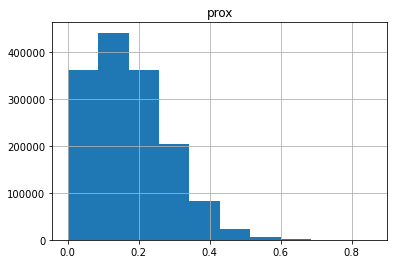

In [13]:
edge_list_1719[["prox"]].hist(); # como se distribuye nuestra medida de proximidad
# esto ya lo hice para todos en el notebook Visualización de matrices de proximidad, solo para chequear 

In [14]:
# cantidad de valores = 0 
sum(i == 0.0 for i in edge_list_1719[["prox"]].unstack()) / sum(i < 1.0 for i in edge_list_1719[["prox"]].unstack())* 100 

8.293960558751028

In [15]:
# cantidad de valores menores a 0.1
sum(i < 0.1 for i in edge_list_1719[["prox"]].unstack()) / sum(i < 1.0 for i in edge_list_1719[["prox"]].unstack())* 100 

28.005665354841504

In [16]:
# cantidad de valores menores a 0.2
sum(i < 0.2 for i in edge_list_1719[["prox"]].unstack()) / sum(i < 1.0 for i in edge_list_1719[["prox"]].unstack())* 100 

61.73385265752713

In [17]:
# número máximo de links
max_links = (prox_matrix1['1719'].shape[0]*prox_matrix1['1719'].shape[0]-prox_matrix1['1719'].shape[0])//2 
max_links

739936

**numpy.tril_indices(n, k=0, m=None)**

Devuelve los índices del triángulo inferior de una matriz (n, m). Por lo que, para los cálculos sólo se toman los valores del triángulo inferior. 

[source](https://numpy.org/doc/stable/reference/generated/numpy.tril_indices.html)

In [18]:
# pruebo con un ejemplo para luego escalar
X = prox_matrix1['1719']

In [19]:
X

,101,102,103,104,105,106,201,202,203,204,...,9615,9616,9617,9618,9701,9702,9703,9704,9705,9706
product_i,,,,,,,,,,,,,,,,,,,,,
101,1.000000,0.250000,0.277778,0.142857,0.266667,0.228571,0.454545,0.352941,0.294118,0.352941,...,0.058824,0.058824,0.000000,0.294118,0.294118,0.294118,0.235294,0.470588,0.352941,0.235294
102,0.250000,1.000000,0.416667,0.361111,0.444444,0.388889,0.444444,0.194444,0.222222,0.250000,...,0.027778,0.083333,0.027778,0.166667,0.055556,0.027778,0.083333,0.166667,0.111111,0.083333
103,0.277778,0.416667,1.000000,0.190476,0.300000,0.285714,0.409091,0.055556,0.388889,0.166667,...,0.000000,0.111111,0.055556,0.222222,0.000000,0.055556,0.000000,0.222222,0.055556,0.055556
104,0.142857,0.361111,0.190476,1.000000,0.433333,0.285714,0.181818,0.095238,0.095238,0.238095,...,0.000000,0.095238,0.000000,0.142857,0.047619,0.000000,0.095238,0.047619,0.142857,0.142857
105,0.266667,0.444444,0.300000,0.433333,1.000000,0.485714,0.366667,0.166667,0.333333,0.166667,...,0.033333,0.100000,0.033333,0.266667,0.100000,0.066667,0.166667,0.133333,0.300000,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9702,0.294118,0.027778,0.055556,0.000000,0.066667,0.057143,0.045455,0.066667,0.076923,0.066667,...,0.142857,0.000000,0.000000,0.125000,0.500000,1.000000,0.384615,0.285714,0.333333,0.363636
9703,0.235294,0.083333,0.000000,0.095238,0.166667,0.142857,0.136364,0.200000,0.153846,0.066667,...,0.000000,0.153846,0.000000,0.187500,0.461538,0.384615,1.000000,0.214286,0.384615,0.538462
9704,0.470588,0.166667,0.222222,0.047619,0.133333,0.085714,0.227273,0.200000,0.214286,0.333333,...,0.000000,0.000000,0.000000,0.187500,0.142857,0.285714,0.214286,1.000000,0.357143,0.142857


In [20]:
# sorted(X.values[np.tril_indices(X.shape[0],-1)]) # paso la matriz a una dimensión -solo la mitad de la matriz, sin repeticiones- y la ordeno 

In [21]:
int(0.1*(X.shape[0]*X.shape[0]-X.shape[0])//2) # para calcular a distintas desidades, el numero de enlaces

73993

In [22]:
# para calcular los umbrales de proximidad según la densidad de aristas definidas -ej. con densidad = 0.1-
sorted(X.values[np.tril_indices(X.shape[0],-1)])[int(0.1*(X.shape[0]*X.shape[0]-X.shape[0])//2)] 

0.04

### Pruebo armar grafos a distintas densidades de aristas

Cabe recordar, que en el paper original utilizan como umbral proximidades mayores a 0.55 para representar.

Para ofrecer una visualización en la que se incluyen todos los productos (en ese caso 775), llegan a todos los nodos calculando el árbol de expansión máxima, que incluye los 774 enlaces maximizando la proximidad agregada del árbol y superpuestos sobre él todos los enlaces con una proximidad mayor a 0.55. Ese conjunto de 1525 enlaces se utiliza para visualizar la estructura de la matriz de proximidad completa, que está lejos de ser homogénea y parece tener una estructura centro-periferia.

In [9]:
def grafos_pordensidad_dict(proximity_matrix:pd.DataFrame, densities:list):
    """
        Toma un dataframe cuadrado (x,x) y una lista de densidades y devuelte
        un diccionario en el que cada densidad es la key y cada value es la
        matriz de adyacencia generada a partir de utilizar la densidad 
        correspondiente como umbral.
        
        Atributos
        ---------
        
        proximity_matrix: pd.DataFrame
            Matriz de proximidades.
            
        densities: list
            Lista de densidades que permitirá generar umbrales para comparar distintos períodos a una mima densidad.
            
        Returns
        -------
        
        Gs: dict
            Diccionario con las densidades como keys y las matrices de 
            adyacencia correspondientes como values.
            
    """
    # cantidad de filas de la matriz (es una matriz cuadrada, así que filas==columnas)
    n = proximity_matrix.shape[0]
    # máxima cantidad de links
    max_links = (n*n-n)//2 
    # conservo la mitad de la matriz ya que es simétrica (me quedo con triangulo inferior)
    tril_idx = np.tril_indices(n,-1) 
    # paso a una dimensión y ordeno
    sorted_proximities = sorted(proximity_matrix.values[tril_idx].flatten(),reverse=True)
    
    # genero grafos y los guardo en diccionario
    Gs = dict()
    for d in densities:
        # pruebo con distinto número de links en base a la densidad definida
        idx = int(d*max_links) 
        # calculo el umbral correspondiente a dicha densidad
        threshold = sorted_proximities[idx] 
        # armo grafos a distintos umbrales segun las densidades previstas
        Gs[round(d,2)] = nx.from_pandas_adjacency(proximity_matrix>=threshold) 
    return Gs

### <span style="color:steelblue">Dataset 1: </span>: todos los períodos - 109 países

In [39]:
# pruebo con densidades base
densidades =  np.arange(0, 1, 0.1)
densidades 

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [69]:
graphs_ = {}
for year in list_years1:
    df_ = prox_matrix1[year]
    Gs_ = grafos_pordensidad_dict(df_, densidades)
    graphs_[year] = Gs_

In [33]:
graphs_ = pickle.load(open("../data/processed/graphs_df1.pkl", "rb"))

In [34]:
graphs_

{'1719': {0.0: <networkx.classes.graph.Graph at 0x1ad9d8ab3a0>,
  0.1: <networkx.classes.graph.Graph at 0x1ad9d8ab460>,
  0.2: <networkx.classes.graph.Graph at 0x1ad9d8ab340>,
  0.3: <networkx.classes.graph.Graph at 0x1ad9d8ab100>,
  0.4: <networkx.classes.graph.Graph at 0x1ad9d8ab5b0>,
  0.5: <networkx.classes.graph.Graph at 0x1ad9568c610>,
  0.6: <networkx.classes.graph.Graph at 0x1ad9568c1c0>,
  0.7: <networkx.classes.graph.Graph at 0x1ad9568c7f0>,
  0.8: <networkx.classes.graph.Graph at 0x1ad9568c340>,
  0.9: <networkx.classes.graph.Graph at 0x1ad9568c910>},
 '0709': {0.0: <networkx.classes.graph.Graph at 0x1ad9568cee0>,
  0.1: <networkx.classes.graph.Graph at 0x1ad9568c6a0>,
  0.2: <networkx.classes.graph.Graph at 0x1ad9568c190>,
  0.3: <networkx.classes.graph.Graph at 0x1ad9568cc70>,
  0.4: <networkx.classes.graph.Graph at 0x1ad9568ce80>,
  0.5: <networkx.classes.graph.Graph at 0x1ad9568c070>,
  0.6: <networkx.classes.graph.Graph at 0x1ad9d8ab820>,
  0.7: <networkx.classes.graph.

In [94]:
# Guardo el diccionario como pickle para poder usarlo luego sin volver a correr todo
# graphs_df1 = open("../data/processed/graphs_df1.pkl", "wb")
# pickle.dump(graphs_, graphs_df1)
# graphs_df1.close()

In [2]:
graphs_ = pickle.load(open("../data/processed/graphs_df1.pkl", "rb"))

In [40]:
# pruebo con otras densidades
densidades2 =  np.arange(0.2, 0.3, 0.01)
densidades2

array([0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29])

In [10]:
graphs2 = {}
for year in list_years1:
    df2 = prox_matrix1[year]
    Gs2 = grafos_pordensidad_dict(df2, densidades2)
    graphs2[year] = Gs2

In [11]:
graphs2

{'1719': {0.2: <networkx.classes.graph.Graph at 0x1ad92343af0>,
  0.21: <networkx.classes.graph.Graph at 0x1ad92343b20>,
  0.22: <networkx.classes.graph.Graph at 0x1ad92343e50>,
  0.23: <networkx.classes.graph.Graph at 0x1ad92343b50>,
  0.24: <networkx.classes.graph.Graph at 0x1ad92343c40>,
  0.25: <networkx.classes.graph.Graph at 0x1ad8a48da90>,
  0.26: <networkx.classes.graph.Graph at 0x1ad8fed4eb0>,
  0.27: <networkx.classes.graph.Graph at 0x1ad8fed4c10>,
  0.28: <networkx.classes.graph.Graph at 0x1ad8fed4ee0>,
  0.29: <networkx.classes.graph.Graph at 0x1ad92343dc0>},
 '0709': {0.2: <networkx.classes.graph.Graph at 0x1ad92343df0>,
  0.21: <networkx.classes.graph.Graph at 0x1ad92343e80>,
  0.22: <networkx.classes.graph.Graph at 0x1ad92343f40>,
  0.23: <networkx.classes.graph.Graph at 0x1ad92343eb0>,
  0.24: <networkx.classes.graph.Graph at 0x1ad92343d60>,
  0.25: <networkx.classes.graph.Graph at 0x1ad92343c70>,
  0.26: <networkx.classes.graph.Graph at 0x1ad92343bb0>,
  0.27: <network

In [13]:
# Guardo el diccionario como pickle para poder usarlo luego sin volver a correr todo
# graphs2_df1 = open("../data/processed/graphs2_df1.pkl", "wb")
# pickle.dump(graphs2, graphs2_df1)
# graphs2_df1.close()

In [3]:
graphs2 = pickle.load(open("../data/processed/graphs2_df1.pkl", "rb"))

In [42]:
#  deprecated (al final defino directamente como key la densidad así puedo luego comparar grafos a distintos años para igual d)
# # me guardo umbrales correspondientes a cada una de las densidades según el período 
# # para poder luego comparar entre años usando el mismo valor de densidades (ya que los umbrales varían según el periodo para una misma densidad)
# umbrales = {}
# for keyP, valuesP in graphs_.items():
#     umbrales[keyP] = valuesP.keys()

In [47]:
# umbrales para las densidades definidas
# {'1719': dict_keys([0.8571428571428571, 0.3214285714285714, 0.2631578947368421, 0.2222222222222222, 0.1875, 0.1578947368421052, 0.1333333333333333, 0.1034482758620689, 0.0714285714285714, 0.04]),
#  '0709': dict_keys([0.90625, 0.3333333333333333, 0.2666666666666666, 0.2222222222222222, 0.1914893617021276, 0.1612903225806451, 0.1333333333333333, 0.1052631578947368, 0.0769230769230769, 0.0434782608695652]),
#  '9799': dict_keys([0.9, 0.3214285714285714, 0.2647058823529412, 0.2222222222222222, 0.1904761904761904, 0.1666666666666666, 0.1333333333333333, 0.1071428571428571, 0.0769230769230769, 0.0476190476190476])}

In [14]:
def plot_heatmaps_dict(graphs_dict:dict, save:bool=False):
    """
        Toma un diccionario que tenga como keys los nombres de los periodos y
        como values, otro diccionario. Este segundo dict tiene como keys las 
        distintas densidades a partir de las cuales se generaron los grafos.
        Ejemplo: { '1719': { 0.1: graph, 0.2: graph, ... } }
        Y genera un heatmap de cada periodo.
        
        Atributos
        ---------
        
        graphs_dict: dict
            Diccionario de grafos.
            
        save: bool, default=False
            Indicador para guardar el gráfico o plotearlo.
            
    """
    ncols = 5
    for year, Gs in graphs_dict.items():
        dmin, dmax = np.min(list(Gs.keys())), np.max(list(Gs.keys()))
        nrows = ceil(len(Gs)/ncols)
        fig, axs = plt.subplots(nrows, ncols, figsize=(20,20))
        fig.suptitle(f'Periodo: {year}', fontsize=24)
        densities = list(Gs.keys())
        r,i = 0,0
        while r<nrows  and i < len(densities):
            c = 0
            while c < ncols and i<len(densities):
                d = densities[i]
                sns.heatmap(nx.to_numpy_array(Gs[d]),cbar=False,cmap="Blues",square=True, ax=axs[r,c])
                axs[r,c].set_title('Edge Density: {:0.2}'.format(d))
                i += 1
                c += 1
            r += 1
        plt.tight_layout()
        plt.subplots_adjust(top=0.98)
        if save:
            folder = os.path.abspath('.').replace('notebooks','figures')
            file_path = os.path.join(folder, 'heatmap_{0}_{1:0.2}-{2:0.2}.png'.format(year,dmin,dmax))
            plt.savefig(file_path)
            plt.close()
            print(f'{file_path} guardado exitosamente.')
        else:
            plt.show()

In [72]:
plot_heatmaps_dict(graphs_, save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\heatmap_1719_0e+00-0.9.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\heatmap_0709_0e+00-0.9.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\heatmap_9799_0e+00-0.9.png guardado exitosamente.


In [15]:
plot_heatmaps_dict(graphs2, save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\heatmap_1719_0.2-0.29.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\heatmap_0709_0.2-0.29.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\heatmap_9799_0.2-0.29.png guardado exitosamente.


In [16]:
def find_shortest_path(graph:nx.Graph):
    """
        Toma un grafo de networkx e intenta calcular el promedio del camino más
        corto.
        Si el grafo no está completamente conectado, calcula todos los
        promedios de caminos más cortos de los subgrafos que sí lo están  y
        devuelve el máximo valor de entre estos promedios.
        
        Atributos
        ---------
        
        graph: nx.Graph
            Grafo de netwrokx.
        
        Returns
        -------
        
        shortest: float
            Promedio de caminos más cortos.
    """
    try:
        shortest = nx.average_shortest_path_length(graph)
    except:
        components_path_length = list()
        for C in (graph.subgraph(c).copy() for c in nx.connected_components(graph)):
            components_path_length.append(nx.average_shortest_path_length(C))
        shortest = np.max(components_path_length)
    return shortest

In [17]:
def calculate_graphs_measures(graphs_dict:dict):
    """
        Toma un diccionario que tenga como keys los nombres de los estadíos y
        como values, otro diccionario. Este segundo dict tiene como keys las
        densidades a partir de las cuales se generaron los grafos.
        Ejemplo: { '1719': { 0.05: graph, 0.1: graph, ... } }
        Y calcula medidas de centralidad, clustering, grado y camino más corto
        promedio para cada estadío y cada densidad.

        Atributos
        ---------
        
        graphs_dict: dict
            Diccionario de grafos.
            
        Returns
        -------
        
        measures: dict
            Diccionario con periodos como keys y dataframes de resumen como
            values.
            
    """
    measures = {}
    for year, Gs in graphs_dict.items():
        # centralidad
        degree_centrality_ = [nx.degree_centrality(G) for G in list(Gs.values())]
        avg_degree_centrality_ = [np.mean(list(i.values())) for i in degree_centrality_]
        betweenness_centrality_ = [nx.betweenness_centrality(G) for G in list(Gs.values())]
        avg_betweenness_centrality_ = [np.mean(list(i.values())) for i in betweenness_centrality_]
        closeness_centrality_ = [nx.closeness_centrality(G) for G in list(Gs.values())]
        avg_closeness_centrality_ = [np.mean(list(i.values())) for i in closeness_centrality_]
        eigenvector_centrality_ = [nx.eigenvector_centrality(G, max_iter=1000) for G in list(Gs.values())]
        avg_eigenvector_centrality_ = [np.mean(list(i.values())) for i in eigenvector_centrality_]
        # grado promedio
        max_degree_ = [np.max(list(dict(G.degree()).values())) for G in list(Gs.values())]
        # camino mínimo
        avg_shortest_path_length_ = [find_shortest_path(G) for G in list(Gs.values())]
        # ceficiente de clustering
        avg_clustering_ = [nx.average_clustering(G) for G in list(Gs.values())]
        df = pd.DataFrame({'d':list(Gs.keys()),
                           'avg_degree_centrality':avg_degree_centrality_,
                           'avg_betweenness_centrality':avg_betweenness_centrality_,
                           'avg_closeness_centrality_':avg_closeness_centrality_,
                           'max_degree':max_degree_,
                           'avg_shortest_path':avg_shortest_path_length_,
                           'avg_clustering':avg_clustering_})
        measures[year] = df
    return measures

In [18]:
measures2 = calculate_graphs_measures(graphs2)
measures2

{'1719':       d  avg_degree_centrality  avg_betweenness_centrality  \
 0  0.20               0.207169                    0.000709   
 1  0.21               0.212067                    0.000703   
 2  0.22               0.245273                    0.000652   
 3  0.23               0.245273                    0.000652   
 4  0.24               0.245273                    0.000652   
 5  0.25               0.254599                    0.000641   
 6  0.26               0.270861                    0.000623   
 7  0.27               0.273499                    0.000620   
 8  0.28               0.285188                    0.000605   
 9  0.29               0.292774                    0.000598   
 
    avg_closeness_centrality_  max_degree  avg_shortest_path  avg_clustering  
 0                   0.540052         632           1.864103        0.494496  
 1                   0.542376         688           1.856577        0.499578  
 2                   0.560301         694           1.794292

In [31]:
# Guardo el diccionario como pickle para poder usarlo luego sin volver a correr todo
# measures2_df1 = open("../data/processed/measures2_df1.pkl", "wb")
# pickle.dump(measures2, measures2_df1)
# measures2_df1.close()

In [35]:
measures = calculate_graphs_measures(graphs_)
measures

{'1719':      d  avg_degree_centrality  avg_betweenness_centrality  \
 0  0.0               0.001649                3.336959e-09   
 1  0.1               0.101659                9.786966e-04   
 2  0.2               0.207169                7.088590e-04   
 3  0.3               0.307996                5.806742e-04   
 4  0.4               0.410000                4.885630e-04   
 5  0.5               0.511829                4.027665e-04   
 6  0.6               0.605370                3.267683e-04   
 7  0.7               0.703349                2.455279e-04   
 8  0.8               0.814065                1.543866e-04   
 9  0.9               0.902683                8.144960e-05   
 
    avg_closeness_centrality_  max_degree  avg_shortest_path  avg_clustering  
 0                   0.000006           5           1.500000        0.000000  
 1                   0.460164         415           2.195003        0.412268  
 2                   0.540052         632           1.864103        0.4

In [36]:
# Guardo el diccionario como pickle para poder usarlo luego sin volver a correr todo
# measures_df1 = open("../data/processed/measures_df1.pkl", "wb")
# pickle.dump(measures, measures_df1)
# measures_df1.close()

In [21]:
# función para graficar una comparación de las distintas medidas de centralidad de los grafos según periodo
def plot_measures(measures_dict:dict, save:bool=False):
    """
        Toma un diccionario con periodos como keys y dataframes con medidas de centralidad como
        values y genera los gráficos para visualizar dichas medidas.
        
        Atributos
        ---------
        
        measures_dict: dict
            Diccionario con dataframes.
            
        save: bool, default=False
            Indicador para guardar el gráfico o plotearlo.
            
    """
    fig = plt.figure(figsize=(20,10))
    measures_list = list(list(measures_dict.values())[0].columns.drop('d'))
    dmin, dmax = np.min(list(measures_dict.values())[0].d), np.max(list(measures_dict.values())[0].d)
    i=1
    for measure in measures_list:
        plt.subplot(2,3,i)
        for year, df in measures_dict.items():
            plt.plot(df.d, df[measure], label=year)
            measure_plot = measure.replace('_',' ')
            plt.title(measure_plot.title())
            plt.xlabel('Edges density')
            plt.ylabel(measure_plot.upper())
            plt.legend()
        i+=1
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    if save:
        folder = os.path.abspath('.').replace('notebooks','figures')
        file_path = os.path.join(folder, 'measures_{0:0.2}-{1:0.2}.png'.format(dmin,dmax))
        plt.savefig(file_path)
        plt.close()
        print(f'{file_path} guardado exitosamente.')
    else:
        plt.show()

In [22]:
plot_measures(measures2, save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\measures_0.2-0.29.png guardado exitosamente.


In [37]:
plot_measures(measures, save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\measures_0.0-0.9.png guardado exitosamente.


In [78]:
# función para plotear los grafos según densidad para los distintos períodos
def plot_graphs_by_density(graphs_dict:dict, list_years:list, save:bool=False):
    """
        Toma un diccionario que tenga como keys los nombres de los periodos y
        como values, otro diccionario. Este segundo dict tiene como keys las
        densidades a partir de las cuales se generaron los grafos.
        Ejemplo: { '1719': { 0.1: graph, 0.2: graph, ... } }
        Y grafica cada grafo por densidad comparando los periodos.

        Atributos
        ---------
        
        graphs_dict: dict
            Diccionario de grafos.
        
        list_years: list
            Lista con los periodos a comparar
        
        save: bool, default=False
            Indicador para guardar el gráfico o plotearlo.
            
        Returns
        ---------
        Plots de grafos por densidad comparando distintos periodos para una misma densidad
            
    """
    densities = list(list(graphs_dict.values())[0].keys())
    
    ncols = 2
    nrows = 2
    colors = sns.color_palette("viridis")
    color_map = dict(zip(list(graphs_dict.keys()), colors))

    for d in densities:
        fig = plt.figure(figsize=(15,10))
        fig.suptitle('Densidad: {:0.1} - Grafo con layout Spring'.format(d), fontsize=20)
        i = 1
        for year in list_years:
            G = graphs_dict[year][d]
            plt.subplot(nrows, ncols, i)
            pos = nx.spring_layout(G,k=0.2,seed=99)
            nx.draw(G,pos=pos, with_labels=True, font_weight='bold', 
                    node_color=np.array([color_map[year]]), alpha=0.5)
            plt.title(f'Periodo: {year}')
            i+=1
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        if save:
            folder = os.path.abspath('.').replace('notebooks','figures')
            file_path = os.path.join(folder, 'graph_by_density_{:0.1}.png'.format(d))
            plt.savefig(file_path)
            plt.close()
            print(f'{file_path} guardado exitosamente.')
        else:
            plt.show()

In [79]:
plot_graphs_by_density(graphs_, list_years1, save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\graph_by_density_0e+00.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\graph_by_density_0.1.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\graph_by_density_0.2.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\graph_by_density_0.3.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\graph_by_density_0.4.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\graph_by_density_0.5.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\graph_by_density_0.6.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\graph_by_density_0.7.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\graph_by_density_0.8.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-

In [ ]:
plot_graphs_by_density(graphs2, list_years1, save=True)

In [159]:
def plot_graphs_by_period(graphs_dict:dict, save:bool=False):
    """
        Toma un diccionario que tenga como keys los nombres de los periodos y
        como values, otro diccionario. Este segundo dict tiene como keys las densidades 
        a partir de las cuales se generaron los grafos.
        
        Y grafica cada grafo por periodo comparando las distintas densidades.
        
        Atributos
        ---------
        graphs_dict: dict
            Diccionario de grafos.
            
        save: bool, default=False
            Indicador para guardar el gráfico o plotearlo.
            
        Returns
        ---------
        Plots de grafos por periodo comparando distintas densidades para un mismo periodo
            
    """
    n_densities = len(list(graphs_dict.values())[0])
    ncol = 2
    nrow = ceil(n_densities/ncol)

    colors = sns.color_palette("winter",n_densities)
    color_map = dict(zip(list(list(graphs_dict.values())[0].keys()), colors))

    for year, Gs in graphs_dict.items():
        fig = plt.figure(figsize=(20,30))
        fig.suptitle(f'Periodo: {year} - Grafo con layout Spring', fontsize=20)
        i = 1
        for d, G in Gs.items():
            plt.subplot(nrow,ncol,i)
            pos = nx.spring_layout(G,k=0.2,seed=99)
            nx.draw(G,pos=pos, with_labels=True, font_weight='bold',
            node_color=np.array([color_map[d]]), alpha=0.5)
            plt.title('Density: {:0.1}'.format(d))
            i += 1
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        if save:
            folder = os.path.abspath('.').replace('notebooks','figures')
            file_path = os.path.join(folder, f'graph_by_stage_{year}.png')
            plt.savefig(file_path)
            plt.close()
            print(f'{file_path} guardado exitosamente.')
        else:
            plt.show()

In [27]:
plot_graphs_by_period(graphs_, save=True)

In [ ]:
plot_graphs_by_period(graphs2, save=True)

In [23]:
def generate_random_graphs(graphs_dict:dict):
    """
        Toma un diccionario que tenga como keys los nombres de los periodos y
        como values, otro diccionario. Este segundo dict tiene como keys las
        densidades a partir de las cuales se generaron los grafos.
        Y genera un diccionario con las mismas características pero en el cual
        los grafos son aleatorios y preservan la misma distribución de nodos y
        aristas.

        Atributos
        ---------
        
        graphs_dict: dict
            Diccionario de grafos.

        Returns
        -------

        random_graphs: dict
            Diccionario de grafos aleatorios.
    """
    random_graphs = dict()
    for year, Gs_dict in graphs_dict.items():
        densities = list(Gs_dict.keys())
        random_graphs[year] = {d: nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges(), seed = densities.index(d)) for d, G in Gs_dict.items()}
    return random_graphs

In [82]:
random_graphs = generate_random_graphs(graphs_)

In [95]:
# # Guardo el diccionario como pickle para poder usarlo luego sin volver a correr todo
# random_graphs_df1 = open("../data/processed/random_graphs_df1.pkl", "wb")
# pickle.dump(random_graphs, random_graphs_df1)
# random_graphs_df1.close()

In [6]:
random_graphs = pickle.load(open("../data/processed/random_graphs_df1.pkl", "rb"))

In [24]:
random_graphs2 = generate_random_graphs(graphs2)

In [25]:
# Guardo el diccionario como pickle para poder usarlo luego sin volver a correr todo
# random_graphs2_df1 = open("../data/processed/random_graphs2_df1.pkl", "wb")
# pickle.dump(random_graphs2, random_graphs2_df1)
# random_graphs2_df1.close()

In [7]:
random_graphs2 = pickle.load(open("../data/processed/random_graphs2_df1.pkl", "rb"))

In [9]:
def plot_distribution_comparisson(original_graphs, random_graphs, save:bool=False):
    """
        Toma dos diccionarios que tenga como keys los nombres de los periodos y
        como values, otro diccionarios. Este segundo dict tiene como keys las
        densidades a partir de las cuales se generaron los grafos.
        
        Genera gráficos comparando las distribuciones de ambos grafos (original vs random)
        a distintos niveles de densidad de aristas para cada periodo.

        Atributos
        ---------
        
        graphs_dict: dict
            Diccionario de grafos.

        Returns
        -------

        random_graphs: dict
            Diccionario de grafos aleatorios.
    """
    for year, Gs_dict in original_graphs.items():
        for d, G in Gs_dict.items():
            # se generan histogramas comparando grafos random vs originales
            fig = plt.figure(figsize=(8,3))
            fig.suptitle('Periodo: {0} - Densidad {1:0.1}'.format(year, d), fontsize=14)
            graphs_degree = pd.DataFrame(G.degree,columns=['Node','Degree']).set_index('Node')
            graphs_degree.hist(bins=10,edgecolor='white', color='slateblue',density=True,ax=plt.subplot(121),label='Grafo original')
            plt.grid(False)
            plt.legend()
            random = random_graphs[year][d]
            random_degree = pd.DataFrame(random.degree,columns=['Node','Degree']).set_index('Node')
            random_degree.hist(bins=10,edgecolor='white', color='slateblue',density=True,ax=plt.subplot(122),label='Random')
            plt.grid(False)
            plt.legend()
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            if save:
                folder = os.path.abspath('.').replace('notebooks','figures')
                file_path = os.path.join(folder, 'dist_comparisson_{0}_{1:0.3}.png'.format(year, d))
                plt.savefig(file_path)
                plt.close()
                print(f'{file_path} guardado exitosamente.')
            else:
                plt.show()

In [86]:
plot_distribution_comparisson(graphs_, random_graphs, save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.0.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.1.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.2.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.3.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.4.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.5.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.6.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.7.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.8.png guardado exitosamente.
C

In [10]:
plot_distribution_comparisson(graphs2, random_graphs2, save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.2.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.21.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.22.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.23.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.24.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.25.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.26.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.27.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\dist_comparisson_1719_0.28.png guardado exitosa

In [26]:
def calculate_louvain_communities(graphs_dict:dict):
    """
        Toma un diccionario que tenga como keys los nombres de los periodos y
        como values, otro diccionario. Este segundo dict tiene como keys las densidades
        a partir de las cuales se generaron los grafos.
       
        
        Genera un diccionario con las medidas de modularidad de comunidades 
        de louvain (Q, NC, comunidades).

        Atributos
        ---------
        
        graphs_dict: dict
            Diccionario de grafos.

        Returns
        -------

        louvain_modularities: dict
            Diccionario de grafos y medidas. Tiene como keys los nombres de los periodos y
            como values, otro diccionario. Este segundo dict tiene como keys las densidades
            a partir de las cuales se generaron los grafos y como values otro diccionario. 
            Este ultimo tiene como keys la identificación de elemento: grafo (G) o 
            medida de modularidad (Q, NC, comunidades)
    """
    louvain_modularities = dict()
    for key, Gs_dict in graphs_dict.items():
        louvain_modularities[key] = dict()
        for d, G in Gs_dict.items():
            # se calculan las comunidades de louvain
            modulos = community_louvain.best_partition(G, random_state=99)
            # se calcula modularidad de las comunidades del paso anterior
            Q = community_louvain.modularity(partition=modulos, graph=G) 
            # se calcula numero de comunidades o modulos
            NC = len(set(modulos.values()))
            # se guarda todo lo obtenido en un diccionario
            louvain_modularities[key][d] = {'G':G,'Q':Q, 'NC':NC,'communities':modulos}
    return louvain_modularities

In [88]:
louv_communities = calculate_louvain_communities(graphs_)

In [92]:
louv_communities

{'1719': {0.0: {'G': <networkx.classes.graph.Graph at 0x236081f5fd0>,
   'Q': 0.9991521096479316,
   'NC': 1214,
   'communities': {'101': 0,
    '102': 1,
    '103': 2,
    '104': 3,
    '105': 4,
    '106': 5,
    '201': 6,
    '202': 7,
    '203': 8,
    '204': 9,
    '205': 10,
    '206': 11,
    '207': 12,
    '208': 13,
    '209': 14,
    '210': 15,
    '301': 16,
    '302': 17,
    '303': 18,
    '304': 19,
    '305': 20,
    '306': 21,
    '307': 22,
    '401': 23,
    '402': 24,
    '403': 25,
    '404': 26,
    '405': 27,
    '406': 28,
    '407': 29,
    '408': 30,
    '409': 31,
    '410': 32,
    '501': 33,
    '502': 34,
    '504': 35,
    '505': 36,
    '506': 37,
    '507': 38,
    '508': 39,
    '510': 40,
    '511': 41,
    '601': 42,
    '602': 43,
    '603': 44,
    '604': 45,
    '701': 46,
    '702': 47,
    '703': 48,
    '704': 49,
    '705': 50,
    '706': 51,
    '707': 52,
    '708': 53,
    '709': 54,
    '710': 55,
    '711': 56,
    '712': 57,
    '713': 5

In [93]:
# # Guardo el diccionario como pickle para poder usarlo luego sin volver a correr todo
# louv_communities_df1 = open("../data/processed/louv_communities_df1.pkl", "wb")
# pickle.dump(louv_communities, louv_communities_df1)
# louv_communities_df1.close()

In [4]:
louv_communities = pickle.load(open("../data/processed/louv_communities_df1.pkl", "rb"))

In [27]:
louv_communities2 = calculate_louvain_communities(graphs2)

In [28]:
# Guardo el diccionario como pickle para poder usarlo luego sin volver a correr todo
# louv_communities2_df1 = open("../data/processed/louv_communities2_df1.pkl", "wb")
# pickle.dump(louv_communities2, louv_communities2_df1)
# louv_communities2_df1.close()

In [5]:
louv_communities2 = pickle.load(open("../data/processed/louv_communities2_df1.pkl", "rb"))

In [98]:
random_louv_communities = calculate_louvain_communities(random_graphs)

In [13]:
random_louv_communities = pickle.load(open("../data/processed/random_louv_communities_df1.pkl", "rb"))

In [29]:
random_louv_communities2 = calculate_louvain_communities(random_graphs2)

In [14]:
random_louv_communities2 = pickle.load(open("../data/processed/random_louv_communities2_df1.pkl", "rb"))

In [30]:
# # Guardo el diccionario como pickle para poder usarlo luego sin volver a correr todo
# random_louv_communities2_df1 = open("../data/processed/random_louv_communities2_df1.pkl", "wb")
# pickle.dump(random_louv_communities2, random_louv_communities2_df1)
# random_louv_communities2_df1.close()

In [15]:
def plot_communities_by_density(community_dict:dict, save:bool=False):
    """
        Toma un diccionario de comunidades (grafos y metricas de comunidades). 
        Tiene como keys los nombres de los periodos y como values, otro diccionario. 
        Este segundo dict tiene como keys las densidades a partir de las cuales se 
        generaron los grafos y como values otro diccionario. Este ultimo tiene como keys 
        la identificación de elemento: grafo (G) o medida de modularidad (Q, NC, comunidades)
        
        Devuelve un plot de cada grafo por densidad comparando los distintos periodos y agregando 
        información de comunidades.

        Atributos
        ---------
        
        graphs_dict: dict
            Diccionario de grafos.
        
        list_years: list
            Lista con los periodos a comparar
        
        save: bool, default=False
            Indicador para guardar el gráfico o plotearlo.
            
        Returns
        ---------
        Plots de grafos por densidad comparando distintos periodos para una misma densidad 
        identificando comunidades y metricas de comunidades
            
    """ 
    densities = list(list(community_dict.values())[0].keys())
    
    ncols = 2
    nrows = 2

    for d in densities:
        fig = plt.figure(figsize=(15,10))
        fig.suptitle('Densidad: {:0.1} - Grafo con layout Spring'.format(d), fontsize=20)
        i = 1
        
        for year in community_dict.keys():
            # se extraen los grafos para generar plots
            G = community_dict[year][d]['G']
            plt.subplot(nrows, ncols, i)
            pos = nx.spring_layout(G,k=0.2,seed=99)
            # se extrae el diccionario con los modulos o comunidades 
            modulos = community_dict[year][d]['communities']
            # se extraen las comunidades a las que pertenece cada producto de la red del dic previo
            values = [v for n,v in modulos.items()]
            # se extraen medidas para agregar info a los gráficos
            NC, Q = community_dict[year][d]['NC'],community_dict[year][d]['Q']
            nx.draw(G, pos=pos, with_labels=True, cmap=plt.cm.tab10, font_weight='bold',
                    node_color = values, font_color='white', edge_color='gray')
            plt.title('Periodo: {0} - NC: {1} - Q: {2:0.1}'.format(year, NC, Q))
            i += 1
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        
        if save:
            folder = os.path.abspath('.').replace('notebooks','figures')
            file_path = os.path.join(folder, 'community_by_density_{:0.1}.png'.format(d))
            plt.savefig(file_path)
            plt.close()
            print(f'{file_path} guardado exitosamente.')
        else:
            plt.show()

In [90]:
plot_communities_by_density(louv_communities, save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\community_by_density_0e+00.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\community_by_density_0.1.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\community_by_density_0.2.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\community_by_density_0.3.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\community_by_density_0.4.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\community_by_density_0.5.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\community_by_density_0.6.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\community_by_density_0.7.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\community_by_density_0.8.png guardado exitosamente.
C:\Users

In [17]:
plot_communities_by_density(louv_communities2, save=True)

In [ ]:
def plot_communities_by_period(community_dict:dict, save:bool=False):
    """
        Toma un diccionario de comunidades (grafos y metricas de comunidades). 
        Tiene como keys los nombres de los periodos y como values, otro diccionario. 
        Este segundo dict tiene como keys las densidades a partir de las cuales se 
        generaron los grafos y como values otro diccionario. Este ultimo tiene como keys 
        la identificación de elemento: grafo (G) o medida de modularidad (Q, NC, comunidades)
        
        Devuelve un plot de cada grafo por periodo comparando las distintas densidades y agregando 
        información de comunidades.

        Atributos
        ---------
        
        graphs_dict: dict
            Diccionario de grafos.
        
        list_years: list
            Lista con los periodos a comparar
        
        save: bool, default=False
            Indicador para guardar el gráfico o plotearlo.
            
        Returns
        ---------
        Plots de grafos por periodo comparando distintas densidades para un mismo periodo 
        identificando comunidades y metricas de comunidades
        
    """    
    n_densities = len(list(community_dict.values())[0].keys())
    
    ncols = 2
    nrows = ceil(n_densities/ncols)
    
    for year, Gs_info in community_dict.items():
        fig = plt.figure(figsize=(20,30))
        fig.suptitle(f'Periodo: {year} - Grafo con layout Spring', fontsize=20)
        i = 1
        
        for d in Gs_info.keys():
            G = Gs_info[d]['G']
            plt.subplot(nrows, ncols, i)
            pos = nx.spring_layout(G,k=0.2,seed=99)
            modulos = Gs_info[d]['communities']
            values = [v for n,v in modulos.items()]
            NC, Q = Gs_info[d]['NC'],Gs_info[d]['Q']
            nx.draw(G,pos=pos, with_labels=True,cmap=plt.cm.tab10,font_weight='bold',node_color = values, font_color='white', edge_color='gray')
            plt.title('Density: {0:0.1} - NC: {1} - Q: {2:0.2}'.format(d, NC, Q))
            i += 1
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        if save:
            folder = os.path.abspath('.').replace('notebooks','figures')
            file_path = os.path.join(folder, f'community_by_period_{year}.png')
            plt.savefig(file_path)
            plt.close()
            print(f'{file_path} guardado exitosamente.')
        else:
            plt.show()

In [97]:
plot_communities_by_period(louv_communities, save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\community_by_period_1719.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\community_by_period_0709.png guardado exitosamente.
C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\community_by_period_9799.png guardado exitosamente.


In [ ]:
plot_communities_by_period(louv_communities2, save=True)

In [88]:
def plot_modularity_measures_lastperiodvsrest(graphs_communities, random_communities=None, errorbar=False,
                                    title:str=None, 
                                    nro_graph:int=None,
                                    save:bool=False):
    """
        Plotea NC y Q.
    """
    measures = {'Q':[0.0,1],'NC':[0,50], 'Q_pvalue_y':0.2, 'NC_pvalue_y':3}
    years = {'0709':'green','9799':'blue'}
    fig = plt.figure(figsize=(15,8))
    if title:
        fig.suptitle(title, fontsize=20)
    i = 1
    for m in ['Q','NC']:
        for y in years.keys():
            densities = list(graphs_communities[y].keys())
            ax = plt.subplot(2,2,i)
            # ax.set_ylim(measures[m])
            plt.title(f'{m.upper()} - {y} vs. 1719',fontsize=16)
            values = [graphs_communities[y][d][m] for d in densities]
            last_values = [graphs_communities['1719'][d][m] for d in densities]
            plt.plot(densities, values, label=y, color=years[y])
            plt.plot(densities, last_values, label='1719', color='black')
            plt.legend(loc = "lower left", fontsize='large')
            plt.xlabel('Densidad (d)')    
            plt.ylabel(m)
            #plt.ylim(measures[m])
            if random_communities:
                # this is an inset axes over the main axes
                random_values = [random_communities[y][d][m] for d in random_communities[y].keys()]
                random_last_values = [random_communities['1719'][d][m] for d in random_communities['1719'].keys()]
                ins = ax.inset_axes([0.6, 0.6, 0.3, 0.3])
                ins.set_title('Random')
                ins.plot(densities, random_values, label=y, color = years[y])
                ins.plot(densities, random_last_values, label='1719' , color = "black")
                ins.set_xlabel('d')
                ins.set_ylabel(m)
                #ins.set_ylim(measures[m])
            i += 1
    plt.tight_layout()
    if title:
        plt.subplots_adjust(top=0.90)
    if save:
        folder = os.path.abspath('.').replace('notebooks','figures')
        file_path = os.path.join(folder, f'modularity_measures_lastperiodvsrest_grafos{nro_graph}.png')
        plt.savefig(file_path)
        plt.close()
        print(f'{file_path} guardado exitosamente.')
    else:
        plt.show()

In [89]:
plot_modularity_measures_lastperiodvsrest(louv_communities, random_louv_communities, errorbar=False, 
                                          title='Modularity comparison Original vs Random', nro_graph=1, save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\modularity_measures_lastperiodvsrest_grafos1.png guardado exitosamente.


In [90]:
plot_modularity_measures_lastperiodvsrest(louv_communities2, random_louv_communities2, errorbar=False, 
                                          title='Modularity comparison Original vs Random 2', nro_graph=2, save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\modularity_measures_lastperiodvsrest_grafos2.png guardado exitosamente.


In [75]:
# Armo una función para graficar Q y NC para los distintos periodos
def plot_con_random(year, louvain_modularities, random_louvain_modularities=None, 
                    metrica:str=None, name_metrica:str=None, col:str=None, save:bool=False):
    """
        Armo una función para graficar Q y NC para los distintos periodos. 
        Hay que indicar: año, metrica, nombre de metrica para gráfico y color. 
        Devuelve un gráfico comparando random vs original louv mod. 

        Toma un diccionario de comunidades (grafos y metricas de comunidades) original y otro random. 
        Tienen como keys los nombres de los periodos y como values, otro diccionario. 
        Este segundo dict tiene como keys las densidades a partir de las cuales se 
        generaron los grafos y como values otro diccionario. Este ultimo tiene como keys 
        la identificación de elemento: grafo (G) o medida de modularidad (Q, NC, comunidades)
                
        Y grafica las metricas de modularidad comparando los restantes periodos con '1719'.

        Atributos
        ---------
        
        year: str
            Define el período a comparar vs '1719'
        
        louvain_modularities: dict
            Diccionario original de comunidades.
            
        random_louvain_modularities: dict
            Diccionario random de comunidades.
        
        metrica: str
            String identificando métrica a graficar (Q o NC)
        
        name_metrica: str 
             String del nombre de la métrica que figurará en el título del gráfico
        
        save: bool, default=False
            Indicador para guardar el gráfico o plotearlo.
            
        Returns
        ---------
        Line plots de métricas de modularidad a distintas densidades comparando periodo seleccionado vs '1719'
            
    """
    if metrica == 'Q':
        ylim = [0, 0.6]
    else:
        ylim = [0, 20]
    
    densities = list(list(louvain_modularities.values())[0].keys())
    year_mod = list(louvain_modularities[year].values())
    year_mod_random = list(random_louvain_modularities[year].values())
    mod_1719 = list(louvain_modularities['1719'].values())
    mod_1719_random = list(random_louvain_modularities['1719'].values())
    metrica_year = [d[metrica] for d in year_mod if metrica in d]
    metrica_year_random = [d[metrica] for d in year_mod_random if metrica in d]
    metrica_1719 = [d[metrica] for d in mod_1719 if metrica in d]
    metrica_1719_random = [d[metrica] for d in mod_1719_random if metrica in d]
    # the main axes is subplot(111) by default
    plt.plot(densities, metrica_year, label=year, color = col)
    # para agregar la error bar 
    # plt.errorbar(densities,mean, sd) cuando calculemos para todos los sujetos;
    plt.plot(densities, metrica_1719, label='1719' , color = "black")
    plt.xlabel('Densidad (d)')
    plt.ylim(ylim)
    plt.ylabel(name_metrica)
    plt.title(f'{name_metrica} 1719 vs. {year} - Louvain')
    plt.legend(loc = "lower left", fontsize='large')
    # this is an inset axes over the main axes
    a = plt.axes([.5, .45, .35, .35])
    plt.plot(densities, metrica_year_random, label=year, color = col)
    plt.plot(densities, metrica_year_random, label='1719' , color = "black")
    plt.xlabel('d')
    plt.ylabel(metrica)
    plt.ylim(ylim)
    plt.title('Random')
    plt.xticks([])
    plt.yticks([])
    if save:
        folder = os.path.abspath('.').replace('notebooks','figures')
        file_path = os.path.join(folder,  f'community_{metrica}_comparison_{year}_1719.png' )
        plt.savefig(file_path)
        plt.close()
        print(f'{file_path} guardado exitosamente.')
    else:
        plt.show()

In [76]:
plot_con_random('0709', louv_communities, random_louv_communities, 'Q', 'Modularidad (Q)' ,'green', save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\community_Q_comparison_0709_1719.png guardado exitosamente.


In [77]:
plot_con_random('9799', louv_communities, random_louv_communities, 'Q', 'Modularidad (Q)' ,'blue', save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\community_Q_comparison_9799_1719.png guardado exitosamente.


In [65]:
plot_con_random('0709', louv_communities, random_louv_communities, 'NC', 'Nro de Comunidades (NC)','green', save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\community_NC_comparison_0709_1719.png guardado exitosamente.


In [66]:
plot_con_random('9799', louv_communities, random_louv_communities, 'NC', 'Nro de Comunidades (NC)','blue', save=True)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\community_NC_comparison_9799_1719.png guardado exitosamente.


In [92]:
# corregir este en adelante
def plot_modularity_measures_by_period_vsRandom(graphs_communities, random_communities=None, 
                                                save:bool=False, nro_graph:int=None):
    """
        Plotea NC y Q.
    """
    measures = {'Q':'blue','NC':'green'}
    fig = plt.figure(figsize=(15,8))
    i = 1
    for m in measures:
        for y in graphs_communities.keys():
            densities = list(graphs_communities[y].keys())
            values = [graphs_communities[y][d][m] for d in graphs_communities[y].keys()]
            random_values = [random_communities[y][d][m] for d in random_communities[y].keys()]
            ax = plt.subplot(2,3,i)
            plt.title(f'{m.upper()} - {y} vs. Random',fontsize=16)
            plt.plot(densities, values, label=y, color=measures[m])
            plt.plot(densities, random_values, label='Random', color='black')
            plt.legend()
            plt.xlabel('Densidad (d)')    
            plt.ylabel(m)
            i += 1
    plt.tight_layout()
    if save:
        folder = os.path.abspath('.').replace('notebooks','figures')
        file_path = os.path.join(folder, f'modularity_measures_by_period_vsRandom_grafos{nro_graph}.png')
        plt.savefig(file_path)
        plt.close()
        print(f'{file_path} guardado exitosamente.')
    else:
        plt.show()

In [94]:
plot_modularity_measures_by_period_vsRandom(louv_communities, random_louv_communities, save=True, nro_graph=1)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\modularity_measures_by_period_vsRandom_grafos1.png guardado exitosamente.


In [95]:
plot_modularity_measures_by_period_vsRandom(louv_communities2, random_louv_communities2, save=True, nro_graph=2)

C:\Users\sofi_\OneDrive\Documentos\Git\prod-space\figures\modularity_measures_by_period_vsRandom_grafos2.png guardado exitosamente.


In [135]:
louv_communities['1719'][0.0]['Q']

0.9991521096479316

In [154]:
# para estudiar si las diferencias entre las métricas de modularidad en cada período son estadisticamente significativas
densities = list(list(louv_communities.values())[0].keys())
dict_1719 = dict()
for d in densities:
    for m in ['Q', 'NC']:
            if m in dict_1719:
                dict_1719[m].append(louv_communities['1719'][d][m])
            else:
                dict_1719[m] = [louv_communities['1719'][d][m]]

In [156]:
dict_0709 = dict()
for d in densities:
    for m in ['Q', 'NC']:
            if m in dict_0709:
                dict_0709[m].append(louv_communities['0709'][d][m])
            else:
                dict_0709[m] = [louv_communities['0709'][d][m]]

In [157]:
dict_9799 = dict()
for d in densities:
    for m in ['Q', 'NC']:
            if m in dict_9799:
                dict_9799[m].append(louv_communities['9799'][d][m])
            else:
                dict_9799[m] = [louv_communities['9799'][d][m]]

In [155]:
dict_1719

{'Q': [0.9991521096479316,
  0.32173747364775573,
  0.2461712540076938,
  0.1960413644198452,
  0.1570085306707341,
  0.11938988600011811,
  0.09719031161122434,
  0.06791246406745993,
  0.047677359755726206,
  0.025377726210785462],
 'NC': [1214, 7, 5, 5, 4, 4, 3, 3, 3, 3]}

In [158]:
# test t de diferencia de medias para evaluar si las diferencias son estadísticamente significativas
ttest_rel(dict_1719['Q'], dict_0709['Q']).pvalue

0.012071698092394521

In [159]:
ttest_rel(dict_1719['Q'], dict_9799['Q']).pvalue

0.0073442371258037415

In [160]:
# test t de diferencia de medias para evaluar si las diferencias son estadísticamente significativas
ttest_rel(dict_1719['NC'], dict_0709['NC']).pvalue

0.5086464915963445

In [161]:
# test t de diferencia de medias para evaluar si las diferencias son estadísticamente significativas
ttest_rel(dict_1719['NC'], dict_9799['NC']).pvalue 

0.21257989232273586

La modularidad presenta diferencias estadísitcamente significativas entre distintos períodos, no así el número de comunidades para cada una de las densidades de aristas estudiadas. 

In [163]:
# para estudiar si las diferencias entre las métricas de modularidad en cada período son estadisticamente significativas
densities2 = list(list(louv_communities2.values())[0].keys())
dict2_1719 = dict()
for d in densities2:
    for m in ['Q', 'NC']:
            if m in dict2_1719:
                dict2_1719[m].append(louv_communities2['1719'][d][m])
            else:
                dict2_1719[m] = [louv_communities2['1719'][d][m]]
                
dict2_0709 = dict()
for d in densities2:
    for m in ['Q', 'NC']:
            if m in dict2_0709:
                dict2_0709[m].append(louv_communities2['0709'][d][m])
            else:
                dict2_0709[m] = [louv_communities2['0709'][d][m]]

dict2_9799 = dict()
for d in densities2:
    for m in ['Q', 'NC']:
            if m in dict2_9799:
                dict2_9799[m].append(louv_communities2['9799'][d][m])
            else:
                dict2_9799[m] = [louv_communities2['9799'][d][m]]                

In [166]:
# test t de diferencia de medias para evaluar si las diferencias son estadísticamente significativas
ttest_rel(dict2_1719['Q'], dict2_0709['Q']).pvalue

0.014990973114905121

In [165]:
ttest_rel(dict2_1719['Q'], dict2_9799['Q']).pvalue

7.059726419091584e-09

In [168]:
# test t de diferencia de medias para evaluar si las diferencias son estadísticamente significativas
ttest_rel(dict2_1719['NC'], dict2_0709['NC']).pvalue

0.0002024993220676408

In [167]:
# test t de diferencia de medias para evaluar si las diferencias son estadísticamente significativas
ttest_rel(dict2_1719['NC'], dict2_9799['NC']).pvalue

1.2681848720135205e-05

In [8]:
def module_partition_dict(communities_dict):
    """
        Toma un diccionario con los nodos como keys y las comunidades como
        values y lo transforma en otro diccionario donde cada key es una
        comunidad y los values son las listas de nodos asignadas a esa 
        comunidad.
        
        Ejemplo:
        
        input:  {0: 3, 1: 3, 2:1, 3: 0, 4: 2, 5:2}
        putput: {0: [3], 1: [2]. 2: [4,5], 3: [0,1]}
        
        Parámetros
        ----------
        communities_dict: dict
            Diccionario con nodos (keys) y comunidades (values).
            
        Return
        ------
        module_partition: dict
            Diccionario con comunidades (keys) y listas de nodos asignados a
            esa comunidad (values).
    """
    module_partition = dict()
    for k, v in communities_dict.items():
        if v not in module_partition:
            module_partition[v] = list()
        module_partition[v].append(k)
    return module_partition

In [9]:
# calculo del coef de participacion que mide la conectividad inter-comunidades
def participation_coefficient(G, module_partition):
    '''
    Computes the participation coefficient of nodes of G with partition
    defined by module_partition.
    (Guimera et al. 2005).

    Parameters
    ----------
    G : :class:`networkx.Graph`
    module_partition : dict
        a dictionary mapping each community name to a list of nodes in G

    Returns
    -------
    dict
        a dictionary mapping the nodes of G to their participation coefficient
        under the participation specified by module_partition.
    '''
    # Initialise dictionary for the participation coefficients
    pc_dict = {}

    # Loop over modules to calculate participation coefficient for each node
    for m in module_partition.keys():
        # Create module subgraph
        M = set(module_partition[m])
        for v in M:
            # Calculate the degree of v in G
            degree = float(nx.degree(G=G, nbunch=v))

            # Calculate the number of intramodule degree of v
            wm_degree = float(sum([1 for u in M if (u, v) in G.edges()]))

            # The participation coeficient is 1 - the square of
            # the ratio of the within module degree and the total degree
            if degree != 0:
                pc_dict[v] = 1 - ((float(wm_degree) / float(degree))**2)
            else:
                pc_dict[v] = 0   

    return pc_dict

In [10]:
# cálculo de z-score que mide las conexiones al interior de las comunidades
def z_score(G, module_partition):
    '''
    Calculate the z-score of the nodes of G under partition module_partition.

    Parameters
    ----------
    G : :class:`networkx.Graph`
    module_partition : dict
        a dictionary mapping each community name to a lists of nodes in G

    Returns
    -------
    dict
        a dictionary mapping the nodes of G to their z-score under
        module_partition.
    '''
    # Initialise dictionary for the z-scores
    z_score = {}

    # Loop over modules to calculate z-score for each node
    for m in module_partition.keys():
        # Create module subgraph
        M = G.subgraph(set(module_partition[m]))           # subgrafo que contiene a los nodos del módulo m
        # Calculate relevant module statistics
        M_degrees = list(dict(M.degree()).values())        # esto se queda con los grados de todos los nodos del subgrafo
        M_degree = np.mean(M_degrees)                      # calcula la media
        M_std = np.std(M_degrees)                          # y el desvío
        for v in M.nodes:
            # Calculate the number of intramodule edges
            wm_edges = float(nx.degree(G=M, nbunch=v))     # esto se queda con los grados del nodo v específicamente
            # Calculate z score as the intramodule degree of v
            # minus the mean intramodule degree, all divided by
            # the standard deviation of intramodule degree
            if M_std != 0:
                zs = (wm_edges - M_degree)/M_std
            else:
                # If M_std is 0, then all M_degrees must be equal.
                # It follows that the intramodule degree of v must equal
                # the mean intramodule degree.
                # It is therefore valid to assign a 0 value to the z-score
                zs = 0
            z_score[v] = zs
    
    return z_score

In [11]:
# se asignan roles considerando los criterios propuestos por Tagliazucchi et al (2013)
def assign_node_type(PC, zscore, pc_threshold, zc_threshold):
    node_type = None
    # si el nodo tiene coef. de participación > Pc y z-score < Zc, es un hub
    if (PC>pc_threshold) and (zscore>zc_threshold):
        node_type = 'hubs'
    # si el nodo tiene coef. de participación < Pc y z-score > Zc, es un prov_hubs
    elif (PC<pc_threshold) and (zscore>zc_threshold):
        node_type = 'prov_hubs'
    # si el nodo tiene coef. de participación < Pc y z-score < Zc, es un prov_nodes
    elif (PC<pc_threshold) and (zscore<zc_threshold):
        node_type = 'prov_nodes'
    # si el nodo tiene coef. de participación > Pc y z-score < Zc, es un connector_nodes
    elif (PC>pc_threshold) and (zscore<zc_threshold):
        node_type = 'connector_nodes'
    return node_type

In [12]:
# arma un df con la identificacion de roles de los nodos en base al cálculo de coef de conexión intra e inter-comunidades
def recognize_nodes_types(graphs_dict, pc_threshold, zc_threshold):
    df_results = pd.DataFrame()
    for year in graphs_dict.keys():
        for densidad in graphs_dict[year].keys():
            G = graphs_dict[year][densidad]['G']
            comunidades = graphs_dict[year][densidad]['communities']
            module_partition = module_partition_dict(comunidades)
            # diccionario con nodos (keys) y coef. de participación (values)
            P = participation_coefficient(G, module_partition) 
            # diccionario con nodos (keys) y z-score (values)
            zscore = z_score(G, module_partition)
            df_P = pd.DataFrame.from_dict(P.items()).rename(columns={0:'node',1:'PC'})
            df_Z = pd.DataFrame.from_dict(zscore.items()).rename(columns={0:'node',1:'zscore'})
            df = df_P.merge(df_Z, how='left', on='node')
            df['densidad'] = densidad
            df['node_type'] = df.apply(lambda x: assign_node_type(
                x.PC, x.zscore,
                pc_threshold=pc_threshold, 
                zc_threshold=zc_threshold
            ),
            axis=1)
            df['periodo'] = year
            df = df[['periodo','densidad','node','node_type','PC','zscore']]
            df_results = df_results.append(df, ignore_index=True)
    return df_results

In [13]:
# calculo de la cantidad de nodos de cada tipo
def calculate_nodes_types_amount(df_node_types):
    types_amount = (
        # se agrupa por columnas seleccionadas
        df_node_types.groupby(['periodo','densidad','node_type']) 
        # se calcula cuántas filas hay de cada combinación
        .size()                                                            
        .reset_index()                                             
        .rename(columns={0:'n_nodes'})
        # se "desacopla" la columna node_types
        .pivot_table(                                                      
            index=['periodo','densidad'],     
            # se arma una columna por tipo de nodo
            columns=['node_type'],   
            # se agrega la cantidad de cada uno en las filas
            values='n_nodes')
        .reset_index()
        .rename_axis(None, axis=1)
    )
    return types_amount

In [79]:
def calculate_pvalue_for_densities(pob1, pob2, column, densities):
    pvalues_list = list()
    for d in densities:
        pob1_values = pob1.loc[pob1.densidad==d,column].values
        pob2_values = pob2.loc[pob2.densidad==d,column].values
        pvalue = ttest_rel(pob1_values, pob2_values, nan_policy='omit').pvalue
        pvalues_list.append(pvalue)
    return pvalues_list

In [278]:
# plot de los roles de los nodos
def plot_nodes_types(nodes_types_df, title:str=None,
                     save:bool=False, file_name:str='nodes_types.png'):
    year = {'0709':'green','9799':'blue'}
    nodes_type = {'hubs':2,'prov_hubs':1,'prov_nodes':20,'connector_nodes':10}
    densities = nodes_types_df.loc[nodes_types_df.periodo=='1719']['densidad']

    i = 1
    fig = plt.figure(figsize=(15,10))
    for nt in nodes_type:
        for y in year:
            df_rest = nodes_types_df.loc[nodes_types_df.periodo==y,['periodo','densidad',nt]]
            df_1719 = nodes_types_df.loc[nodes_types_df.periodo=='1719',['periodo','densidad',nt]]
            pvalues = calculate_pvalue_for_densities(df_rest, df_1719, column=nt, densities=densities)
            signif = [i for i,p in enumerate(pvalues) if p<0.05]
            signif_dens = [densities[p] for p in signif]
            ax = plt.subplot(4,2,i)
            plt.plot(densities, df_rest.loc[df_rest.periodo==y][nt], label=y, color=year[y])
            plt.plot(densities, df_1719[nt], label='1719', color='black')
            plt.scatter(signif_dens, [nodes_type[nt]]*len(signif_dens), marker='*',color='black')
            plt.title(f'{y} vs. 1719', fontsize=16)
            plt.legend()
            plt.ylabel(nt.replace('_',' ').title())
            i += 1
    plt.tight_layout()
    if title:
        fig.suptitle(title, fontsize=20)
        plt.subplots_adjust(top=0.90)
    if save:
        folder = os.path.abspath('.').replace('notebooks','figures')
        file_path = os.path.join(folder, file_name)
        plt.savefig(file_path)
        plt.close()
        print(f'{file_path} guardado exitosamente.')
    else:
        plt.show()

In [17]:
node_types = recognize_nodes_types(louv_communities, pc_threshold=0.05, zc_threshold=1)

In [18]:
node_types

,periodo,densidad,node,node_type,PC,zscore
0,1719,0.0,101,connector_nodes,0.750000,0.000000
1,1719,0.0,102,connector_nodes,0.750000,0.000000
2,1719,0.0,103,connector_nodes,0.750000,0.000000
3,1719,0.0,104,connector_nodes,0.750000,0.000000
4,1719,0.0,105,connector_nodes,0.750000,0.000000
...,...,...,...,...,...,...
36505,9799,0.9,201,connector_nodes,0.996929,0.673432
36506,9799,0.9,2827,connector_nodes,0.997081,0.673432
36507,9799,0.9,7502,connector_nodes,0.994724,-0.935873
36508,9799,0.9,2504,connector_nodes,0.996995,-0.292151


In [19]:
node_types2 = recognize_nodes_types(louv_communities2, pc_threshold=0.05, zc_threshold=1)

In [20]:
# para cada nodo de cada periodo-densidad, calculo cuántos nodos de cada tipo hay
df_results = calculate_nodes_types_amount(node_types)

In [21]:
df_results

,periodo,densidad,connector_nodes,hubs,prov_hubs,prov_nodes
0,0709,0.0,1217.0,NaN,NaN,NaN
1,0709,0.1,985.0,217.0,NaN,15.0
2,0709,0.2,960.0,216.0,1.0,40.0
3,0709,0.3,1034.0,178.0,NaN,5.0
4,0709,0.4,1064.0,150.0,NaN,3.0
5,0709,0.5,1091.0,126.0,NaN,NaN
6,0709,0.6,1154.0,63.0,NaN,NaN
7,0709,0.7,1191.0,26.0,NaN,NaN
8,0709,0.8,1214.0,3.0,NaN,NaN
9,0709,0.9,1217.0,NaN,NaN,NaN


In [67]:
df_results.loc[df_results.periodo=='0709']['hubs']

0      NaN
1    217.0
2    216.0
3    178.0
4    150.0
5    126.0
6     63.0
7     26.0
8      3.0
9      NaN
Name: hubs, dtype: float64

In [58]:
df_results.loc[df_results.periodo=='1719']['densidad']

10    0.0
11    0.1
12    0.2
13    0.3
14    0.4
15    0.5
16    0.6
17    0.7
18    0.8
19    0.9
Name: densidad, dtype: float64

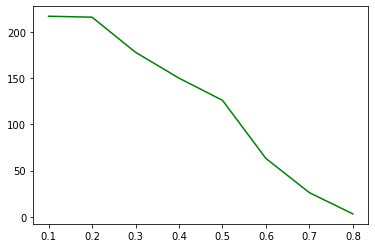

In [46]:
plt.plot(densidades, df_results.loc[df_results.periodo=='0709']['hubs'], label='0709', color='green')

In [23]:
df_results2 = calculate_nodes_types_amount(node_types2)
df_results2

,periodo,densidad,connector_nodes,hubs,prov_hubs,prov_nodes
0,0709,0.20,999.0,209.0,NaN,9.0
1,0709,0.21,997.0,215.0,NaN,5.0
2,0709,0.22,974.0,205.0,1.0,37.0
3,0709,0.23,1009.0,204.0,NaN,4.0
4,0709,0.24,1009.0,204.0,NaN,4.0
5,0709,0.25,1009.0,204.0,NaN,4.0
6,0709,0.26,1014.0,193.0,NaN,10.0
7,0709,0.27,1020.0,191.0,NaN,6.0
8,0709,0.28,1023.0,187.0,NaN,7.0
9,0709,0.29,1023.0,187.0,NaN,7.0


C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\_methods.py:253: Ru

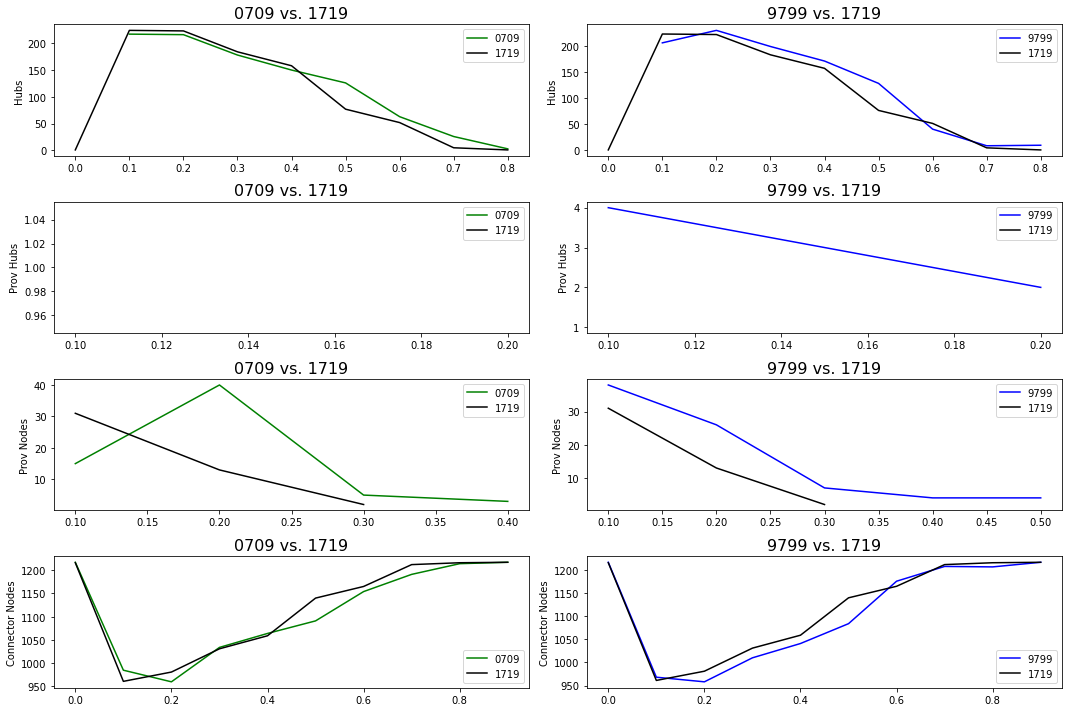

In [279]:
plot_nodes_types(df_results)

In [78]:
ttest_rel(df_results.loc[df_results.periodo=='0709']['hubs'], df_results.loc[df_results.periodo=='1719']['hubs'], nan_policy='omit')

Ttest_relResult(statistic=0.9745586289152093, pvalue=0.3622459874562562)

In [83]:
ttest_rel(df_results.loc[df_results.periodo=='0709']['connector_nodes'], df_results.loc[df_results.periodo=='1719']['connector_nodes'], nan_policy='omit')

Ttest_relResult(statistic=-1.1361171523420956, pvalue=0.28525403473858746)

In [84]:
ttest_rel(df_results.loc[df_results.periodo=='0709']['prov_nodes'], df_results.loc[df_results.periodo=='1719']['prov_nodes'], nan_policy='omit')

Ttest_relResult(statistic=0.37510467550797033, pvalue=0.7436258602539704)

C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\_methods.py:253: Ru

C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\sofi_\miniconda3\lib\site-packages\numpy\core\_methods.py:253: Ru

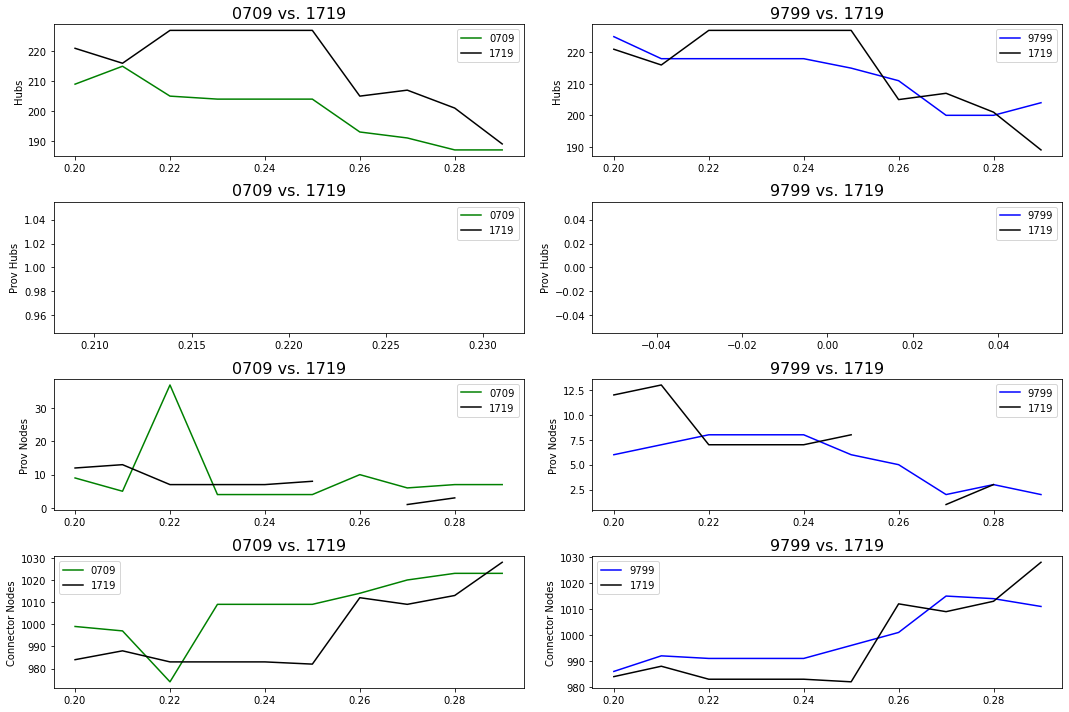

In [85]:
plot_nodes_types(df_results2)

In [99]:
dt = [[0, 'Alimentos y animales vivos principalmente para alimentos', 'Alimentos y animales'], [1, 'Bebidas y tabaco', 'Bebidas y tabaco'], [2, 'Materias primas no comestibles, excepto combustibles', 'Materias primas'],[3, 
              'Combustibles minerales, lubricantes y materiales relacionados', 'Combustibles'], [4, 'Aceites, grasas y ceras animales y vegetales', 'Aceites y grasas'], [5, 'Productos químicos y productos afines, nep', 'Productos químicos'],
              [6, 'Productos manufacturados clasificados principalmente por materiales', 'Productos manufacturados'], [7, 'Maquinaria y equipo de transporte', 'Maq y equipo de transporte'], [8, 'Manufacturas diversas', 'Otras manufacturas'],
              [9, 'Materias primas y transacciones no clasificadas en otra parte de la CUCI', 'Otras materias primas']]
dt

[[0,
  'Alimentos y animales vivos principalmente para alimentos',
  'Alimentos y animales'],
 [1, 'Bebidas y tabaco', 'Bebidas y tabaco'],
 [2,
  'Materias primas no comestibles, excepto combustibles',
  'Materias primas'],
 [3,
  'Combustibles minerales, lubricantes y materiales relacionados',
  'Combustibles'],
 [4, 'Aceites, grasas y ceras animales y vegetales', 'Aceites y grasas'],
 [5, 'Productos químicos y productos afines, nep', 'Productos químicos'],
 [6,
  'Productos manufacturados clasificados principalmente por materiales',
  'Productos manufacturados'],
 [7, 'Maquinaria y equipo de transporte', 'Maq y equipo de transporte'],
 [8, 'Manufacturas diversas', 'Otras manufacturas'],
 [9,
  'Materias primas y transacciones no clasificadas en otra parte de la CUCI',
  'Otras materias primas']]

In [100]:
categ = pd.DataFrame(dt, columns=['Category', 'Desc_Categ', 'Desc_Categ_short'])
categ

,Category,Desc_Categ,Desc_Categ_short
0,0,Alimentos y animales vivos principalmente para...,Alimentos y animales
1,1,Bebidas y tabaco,Bebidas y tabaco
2,2,"Materias primas no comestibles, excepto combus...",Materias primas
3,3,"Combustibles minerales, lubricantes y material...",Combustibles
4,4,"Aceites, grasas y ceras animales y vegetales",Aceites y grasas
5,5,"Productos químicos y productos afines, nep",Productos químicos
6,6,Productos manufacturados clasificados principa...,Productos manufacturados
7,7,Maquinaria y equipo de transporte,Maq y equipo de transporte
8,8,Manufacturas diversas,Otras manufacturas
9,9,Materias primas y transacciones no clasificada...,Otras materias primas


In [108]:
list_years1 = ['1719', '0709', '9799']
# levanto las matrices y por ahora descarto las descripciones
dfs_prox_matrix = {}
for i in list_years1:
    df = pd.read_csv(f'../data/processed/prox_matix_desc_{i}_df1.csv')
    df = df.set_index(df.product_i)
    df = df.set_index(df.index.astype(str))
    df = df.merge(categ, how='left', on='Category')
    dfs_prox_matrix[i] = df

In [198]:
clasif_nodes = dfs_prox_matrix['1719'][['HS_code', 'HS_description', 'es_bio_prod', 'Category', 'Desc_Categ', 'Desc_Categ_short']]
clasif_nodes

,HS_code,HS_description,es_bio_prod,Category,Desc_Categ,Desc_Categ_short
0,101,"Live horses, asses, mules and hinnies.",True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales
1,102,Live bovine animals.,True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales
2,103,Live swine.,True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales
3,104,Live sheep and goats.,True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales
4,105,"Live poultry, that is to say, fowls of the spe...",True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales
...,...,...,...,...,...,...
1212,9702,"Original engravings, prints and lithographs.",False,8,Manufacturas diversas,Otras manufacturas
1213,9703,"Original sculptures and statuary, in any mater...",False,8,Manufacturas diversas,Otras manufacturas
1214,9704,"Postage or revenue stamps, stamp-postmarks, fi...",False,8,Manufacturas diversas,Otras manufacturas
1215,9705,Collections and collectors' pieces of zoologic...,False,8,Manufacturas diversas,Otras manufacturas


In [199]:
clasif_nodes['HS_code'] = clasif_nodes['HS_code'].map(str)

<ipython-input-199-17fb0a998290>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clasif_nodes['HS_code'] = clasif_nodes['HS_code'].map(str)


In [200]:
clasif_nodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 0 to 1216
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   HS_code           1217 non-null   object
 1   HS_description    1217 non-null   object
 2   es_bio_prod       1217 non-null   bool  
 3   Category          1217 non-null   int64 
 4   Desc_Categ        1217 non-null   object
 5   Desc_Categ_short  1217 non-null   object
dtypes: bool(1), int64(1), object(4)
memory usage: 58.2+ KB


In [201]:
node_types_categ = node_types.merge(clasif_nodes, how='left', left_on='node', right_on='HS_code')
node_types_categ2 = node_types2.merge(clasif_nodes, how='left', left_on='node', right_on='HS_code')

In [202]:
node_types_categ.head()

,periodo,densidad,node,node_type,PC,zscore,HS_code,HS_description,es_bio_prod,Category,Desc_Categ,Desc_Categ_short
0,1719,0.0,101,connector_nodes,0.75,0.0,101,"Live horses, asses, mules and hinnies.",True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales
1,1719,0.0,102,connector_nodes,0.75,0.0,102,Live bovine animals.,True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales
2,1719,0.0,103,connector_nodes,0.75,0.0,103,Live swine.,True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales
3,1719,0.0,104,connector_nodes,0.75,0.0,104,Live sheep and goats.,True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales
4,1719,0.0,105,connector_nodes,0.75,0.0,105,"Live poultry, that is to say, fowls of the spe...",True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales


In [203]:
node_types_categ.node_type.apply(lambda x:
                                 ''.join([i[0].title() for i in x.split('_')])
                                 if type(x) == str else x).unique()

array(['CN', 'H', 'PN', 'PH'], dtype=object)

In [204]:
# agrego abreviatura de roles de nodos para graficar luego más fácil
node_types_categ['node_type_abr'] = node_types_categ.node_type.apply(lambda x:
                                 ''.join([i[0].title() for i in x.split('_')])
                                 if type(x) == str else x)
node_types_categ2['node_type_abr'] = node_types_categ2.node_type.apply(lambda x:
                                 ''.join([i[0].title() for i in x.split('_')])
                                 if type(x) == str else x)

In [205]:
node_types_categ.head()

,periodo,densidad,node,node_type,PC,zscore,HS_code,HS_description,es_bio_prod,Category,Desc_Categ,Desc_Categ_short,node_type_abr
0,1719,0.0,101,connector_nodes,0.75,0.0,101,"Live horses, asses, mules and hinnies.",True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales,CN
1,1719,0.0,102,connector_nodes,0.75,0.0,102,Live bovine animals.,True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales,CN
2,1719,0.0,103,connector_nodes,0.75,0.0,103,Live swine.,True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales,CN
3,1719,0.0,104,connector_nodes,0.75,0.0,104,Live sheep and goats.,True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales,CN
4,1719,0.0,105,connector_nodes,0.75,0.0,105,"Live poultry, that is to say, fowls of the spe...",True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales,CN


In [230]:
# agrego abreviatura de rol y categoría en una sola columna para después podes plotear más fácil
node_types_categ['full_info'] = node_types_categ.apply(lambda x:
                                                       x.node_type_abr+'-'+x.Desc_Categ_short
                                                       if type(x.node_type_abr) == str
                                                       else 'NA-'+x.Desc_Categ_short, axis=1)
node_types_categ2['full_info'] = node_types_categ2.apply(lambda x:
                                                       x.node_type_abr+'-'+x.Desc_Categ_short
                                                       if type(x.node_type_abr) == str
                                                       else 'NA-'+x.Desc_Categ_short, axis=1)

In [207]:
node_types_categ.head()

,periodo,densidad,node,node_type,PC,zscore,HS_code,HS_description,es_bio_prod,Category,Desc_Categ,Desc_Categ_short,node_type_abr,full_info
0,1719,0.0,101,connector_nodes,0.75,0.0,101,"Live horses, asses, mules and hinnies.",True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales,CN,CN-Alimentos y animales
1,1719,0.0,102,connector_nodes,0.75,0.0,102,Live bovine animals.,True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales,CN,CN-Alimentos y animales
2,1719,0.0,103,connector_nodes,0.75,0.0,103,Live swine.,True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales,CN,CN-Alimentos y animales
3,1719,0.0,104,connector_nodes,0.75,0.0,104,Live sheep and goats.,True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales,CN,CN-Alimentos y animales
4,1719,0.0,105,connector_nodes,0.75,0.0,105,"Live poultry, that is to say, fowls of the spe...",True,0,Alimentos y animales vivos principalmente para...,Alimentos y animales,CN,CN-Alimentos y animales


In [231]:
# selecciono densidad == 0.2 para graficar
roles_por_periodo = df_results[df_results.densidad==0.2]
# selecciono densidad == 0.2 para graficar
roles_por_periodo2 = df_results2[df_results2.densidad==0.25]

In [237]:
roles_por_periodo = pd.melt(roles_por_periodo, id_vars=['periodo'], var_name='roles', value_name='valores')
roles_por_periodo = roles_por_periodo[roles_por_periodo.roles!='densidad']
roles_por_periodo['rol_short'] = roles_por_periodo.roles.apply(lambda x:
                                 ''.join([i[0].title() for i in x.split('_')])
                                 if type(x) == str else x)

In [232]:
roles_por_periodo2 = pd.melt(roles_por_periodo2, id_vars=['periodo'], var_name='roles', value_name='valores')
roles_por_periodo2 = roles_por_periodo2[roles_por_periodo2.roles!='densidad']
roles_por_periodo2['rol_short'] = roles_por_periodo2.roles.apply(lambda x:
                                 ''.join([i[0].title() for i in x.split('_')])
                                 if type(x) == str else x)

In [233]:
roles_por_periodo2

,periodo,roles,valores,rol_short
3,0709,connector_nodes,1009.0,CN
4,1719,connector_nodes,982.0,CN
5,9799,connector_nodes,996.0,CN
6,0709,hubs,204.0,H
7,1719,hubs,227.0,H
8,9799,hubs,215.0,H
9,0709,prov_hubs,NaN,PH
10,1719,prov_hubs,NaN,PH
11,9799,prov_hubs,NaN,PH
12,0709,prov_nodes,4.0,PN


La siguiente función para agregar los valores al gráfico fue obtenida de [Stackoverflow](https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart)

In [236]:
# función para agregar valores al barplot
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values

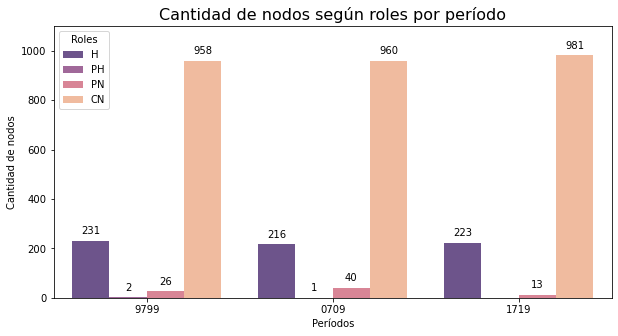

In [272]:
fig = plt.figure(figsize=(10,5))
g = sns.barplot(x='periodo', y='valores',
                 data=roles_por_periodo, order=['9799','0709','1719'], 
                 hue='rol_short', hue_order=['H','PH','PN','CN'], palette='magma', alpha=0.75)
g.set_xlabel('Períodos')
g.set_ylabel('Cantidad de nodos')
g.set_ylim(0, 1100)
g.set_title('Cantidad de nodos según roles por período', fontsize=16)
g.legend(title='Roles')
#plt.show()

# Call the function above. All the magic happens there.
add_value_labels(g)
plt.savefig('../figures/nodes_rol_by_period.png')

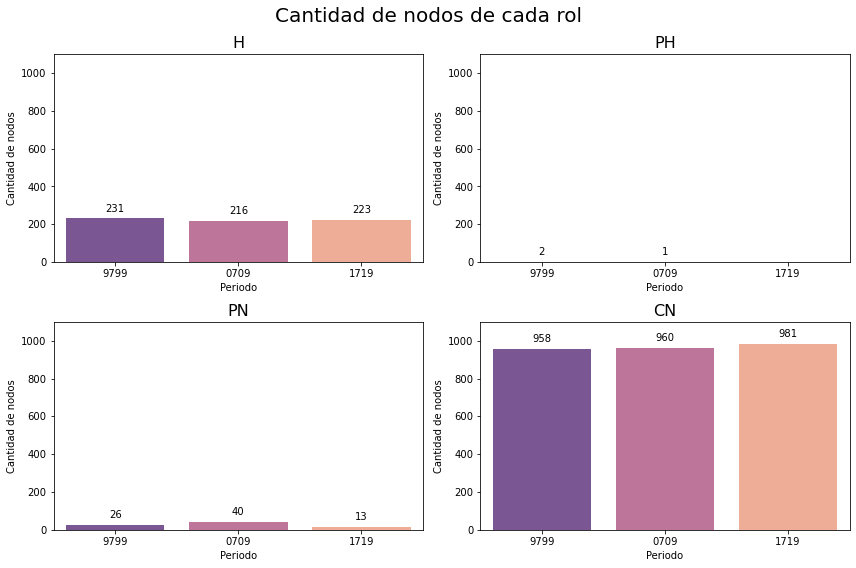

In [271]:
fig = plt.figure(figsize=(12,8))
i = 1
for rol in ['H','PH','PN','CN']:
    df = roles_por_periodo[roles_por_periodo.rol_short==rol]
    ax = plt.subplot(2,2,i)
    sns.barplot(x='periodo', y='valores', order=['9799','0709','1719'], 
                data=df,
                ax=ax, palette='magma', alpha=0.75)
    ax.set_xlabel('Periodo')
    ax.set_ylabel('Cantidad de nodos')
    ax.set_ylim(0, 1100)
    ax.set_title(f'{rol.upper()}', fontsize=16)
    add_value_labels(ax)
    #ax.set_ylim([0,60])
    i += 1
plt.suptitle('Cantidad de nodos de cada rol', fontsize=20)

plt.tight_layout()
#plt.show()
plt.savefig('../figures/nodes_rol.png')

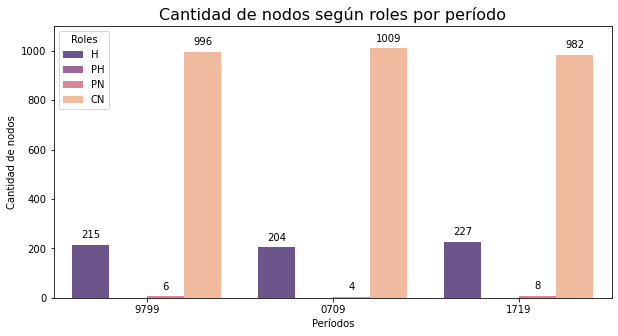

In [270]:
fig = plt.figure(figsize=(10,5))
g = sns.barplot(x='periodo', y='valores',
                 data=roles_por_periodo2, order=['9799','0709','1719'], 
                 hue='rol_short', hue_order=['H','PH','PN','CN'], palette='magma', alpha=0.75)
g.set_xlabel('Períodos')
g.set_ylabel('Cantidad de nodos')
g.set_ylim(0, 1100)
g.set_title('Cantidad de nodos según roles por período', fontsize=16)
g.legend(title='Roles')
#plt.show()

# Call the function above. All the magic happens there.
add_value_labels(g)
plt.savefig('../figures/nodes_rol_by_period2.png')

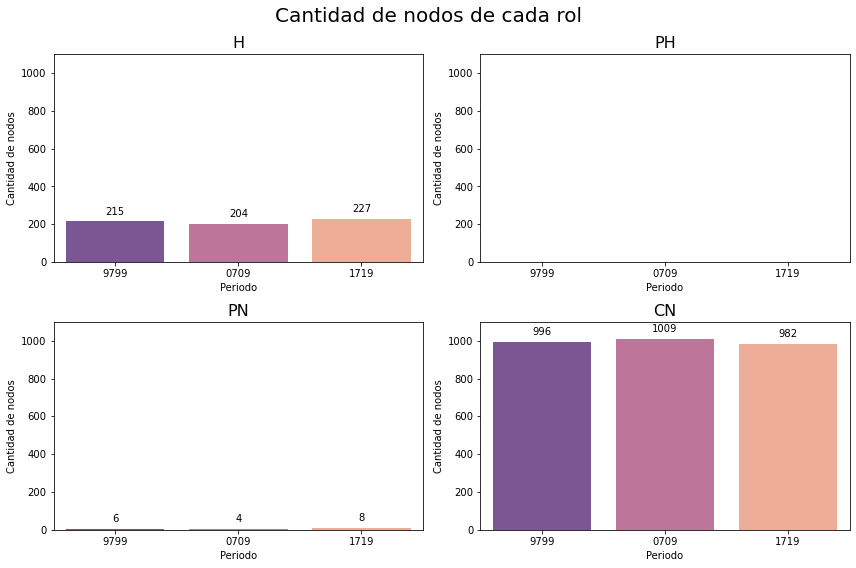

In [269]:
fig = plt.figure(figsize=(12,8))
i = 1
for rol in ['H','PH','PN','CN']:
    df = roles_por_periodo2[roles_por_periodo2.rol_short==rol]
    ax = plt.subplot(2,2,i)
    sns.barplot(x='periodo', y='valores', order=['9799','0709','1719'], 
                data=df,
                ax=ax, palette='magma', alpha=0.75)
    ax.set_xlabel('Periodo')
    ax.set_ylabel('Cantidad de nodos')
    ax.set_ylim(0, 1100)
    ax.set_title(f'{rol.upper()}', fontsize=16)
    add_value_labels(ax)
    #ax.set_ylim([0,60])
    i += 1
plt.suptitle('Cantidad de nodos de cada rol', fontsize=20)

plt.tight_layout()
#plt.show()
plt.savefig('../figures/nodes_rol2.png')

In [221]:
# analizo las categorías que incluirían hubs 
node_types_categ[(node_types_categ.node_type_abr=='H')&(node_types_categ.periodo=='1719')&(node_types_categ.densidad==0.2)].Desc_Categ_short.unique()

array(['Productos químicos', 'Productos manufacturados',
       'Maq y equipo de transporte', 'Otras manufacturas',
       'Alimentos y animales', 'Combustibles', 'Materias primas',
       'Bebidas y tabaco'], dtype=object)

In [218]:
node_types_categ[(node_types_categ.node_type_abr=='H')&(node_types_categ.periodo=='1719')&(node_types_categ.densidad==0.2)].node.unique()

array(['2921', '8208', '8421', '8707', '8479', '3919', '7225', '7220',
       '8483', '3005', '8514', '1501', '3907', '8413', '9025', '8202',
       '8427', '2920', '6814', '3002', '7608', '3911', '8477', '2912',
       '7219', '7318', '3801', '3505', '8511', '7115', '3819', '5911',
       '8207', '8475', '8512', '7222', '3403', '3815', '7505', '2903',
       '9027', '3913', '3908', '7014', '8481', '3504', '5603', '3906',
       '2910', '8482', '2925', '8701', '8467', '4006', '9017', '8466',
       '9209', '9031', '8409', '2906', '3909', '3507', '6804', '8515',
       '8484', '6903', '2526', '8546', '2823', '2914', '8458', '8101',
       '3804', '2916', '3905', '3810', '9022', '8203', '8448', '9604',
       '6805', '3914', '3821', '4906', '8526', '3812', '8709', '8403',
       '3813', '8455', '8408', '3922', '3402', '7212', '3917', '2104',
       '7310', '4818', '5602', '4417', '4410', '2103', '2105', '4902',
       '4008', '7306', '7308', '9406', '7309', '9403', '1905', '3307',
      

In [226]:
# veo cuantos hubs hay para la categoria alimentos y animales y a qué nodos (prods) corresponden
node_types_categ[(node_types_categ.node_type_abr=='H')&(node_types_categ.periodo=='1719')&(node_types_categ.densidad==0.2)&(node_types_categ.Desc_Categ_short=='Alimentos y animales')].node.unique()

array(['1501', '8403', '2104', '2103', '2105', '1905', '403', '1601',
       '2001', '1904', '105', '2005', '813', '2309', '2007', '1517',
       '401', '811', '406', '408', '407', '812'], dtype=object)

In [229]:
# veo cuantos hubs hay de productos bio y a qué nodos (prods) corresponden
node_types_categ[(node_types_categ.node_type_abr=='H')&(node_types_categ.periodo=='1719')&(node_types_categ.densidad==0.2)&(node_types_categ.es_bio_prod==True)].node.unique()

array(['2921', '3005', '1501', '2920', '3002', '2912', '3505', '3819',
       '5911', '3403', '3815', '2903', '3504', '5603', '2910', '2925',
       '2906', '3507', '2823', '2914', '2916', '3810', '3821', '3812',
       '3813', '3402', '2104', '4818', '5602', '4417', '4410', '2103',
       '2105', '9403', '1905', '3307', '4819', '4415', '4408', '403',
       '1601', '2001', '4822', '4821', '1904', '105', '6101', '2005',
       '813', '2309', '2007', '1517', '401', '4823', '811', '4805',
       '3305', '4413', '406', '408', '2403', '4418', '407', '6507',
       '5210', '4304', '5807', '4203', '5309', '5212', '2941', '5808',
       '5107', '5209', '5408', '5902', '6302', '6114', '5801', '6201',
       '812', '5510', '5106', '6214', '5804', '5509', '5515', '9401',
       '5308', '5403', '5206', '6216', '6111', '5407', '5811'],
      dtype=object)

In [261]:
roles_por_categ = node_types_categ[node_types_categ.densidad==0.2].groupby(['periodo','node_type_abr','Desc_Categ_short'])['node_type_abr'].count().reset_index(name='rol')
roles_por_categ.head()

,periodo,node_type_abr,Desc_Categ_short,rol
0,0709,CN,Aceites y grasas,20
1,0709,CN,Alimentos y animales,113
2,0709,CN,Bebidas y tabaco,10
3,0709,CN,Combustibles,15
4,0709,CN,Maq y equipo de transporte,119


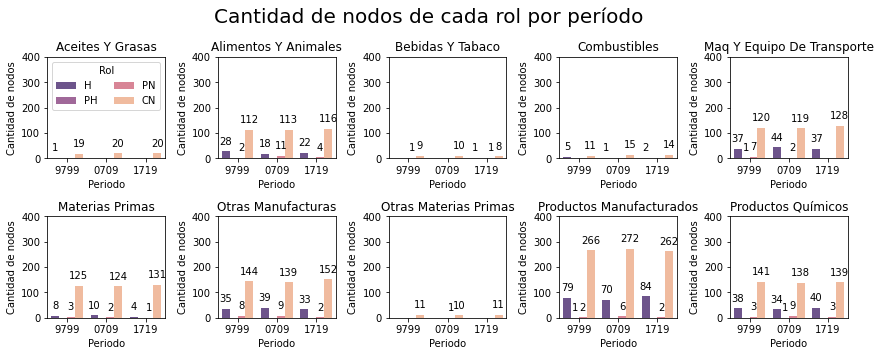

In [274]:
fig = plt.figure(figsize=(12,5))
i = 1
for categ in roles_por_categ.Desc_Categ_short.unique():
    df = roles_por_categ[roles_por_categ.Desc_Categ_short==categ]
    ax = plt.subplot(2,5,i)
    sns.barplot(x='periodo', y='rol',
                data=df, order=['9799','0709','1719'], 
                hue='node_type_abr', hue_order=['H','PH','PN','CN'],
                ax=ax, palette='magma', alpha=0.75)
    ax.set_xlabel('Periodo')
    ax.set_ylabel('Cantidad de nodos')
    ax.set_ylim(0, 400)
    ax.set_title(f'{categ.title()}', fontsize=12)
    add_value_labels(ax)
    if i == 1:
        ax.legend(title='Rol', loc='upper left', mode='expand',ncol=2)
    else:
        ax.get_legend().remove()
    #ax.set_ylim([0,25])
    i += 1
plt.suptitle('Cantidad de nodos de cada rol por período', fontsize=20)
plt.tight_layout()
#plt.show()
plt.savefig('../nodes_rol_by_period_categ.png')

In [267]:
roles_por_categ2 = node_types_categ2[node_types_categ2.densidad==0.25].groupby(['periodo','node_type_abr','Desc_Categ_short'])['node_type_abr'].count().reset_index(name='rol')
roles_por_categ2.head()

,periodo,node_type_abr,Desc_Categ_short,rol
0,0709,CN,Aceites y grasas,20
1,0709,CN,Alimentos y animales,119
2,0709,CN,Bebidas y tabaco,10
3,0709,CN,Combustibles,14
4,0709,CN,Maq y equipo de transporte,132


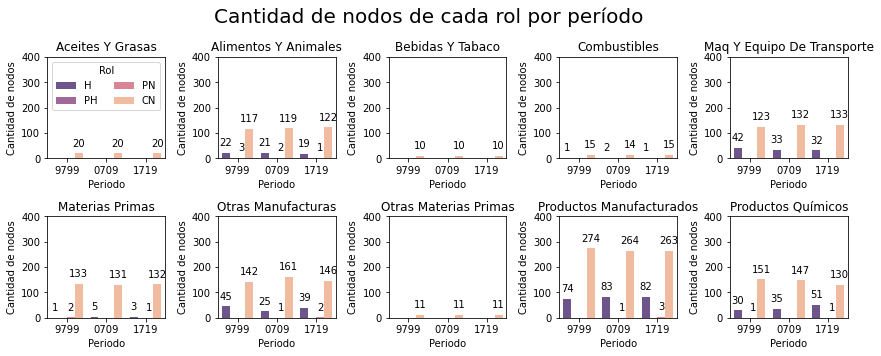

In [275]:
fig = plt.figure(figsize=(12,5))
i = 1
for categ in roles_por_categ2.Desc_Categ_short.unique():
    df = roles_por_categ2[roles_por_categ2.Desc_Categ_short==categ]
    ax = plt.subplot(2,5,i)
    sns.barplot(x='periodo', y='rol',
                data=df, order=['9799','0709','1719'], 
                hue='node_type_abr', hue_order=['H','PH','PN','CN'],
                ax=ax, palette='magma', alpha=0.75)
    ax.set_xlabel('Periodo')
    ax.set_ylabel('Cantidad de nodos')
    ax.set_ylim(0, 400)
    ax.set_title(f'{categ.title()}', fontsize=12)
    add_value_labels(ax)
    if i == 1:
        ax.legend(title='Rol', loc='upper left', mode='expand',ncol=2)
    else:
        ax.get_legend().remove()
    #ax.set_ylim([0,25])
    i += 1
plt.suptitle('Cantidad de nodos de cada rol por período', fontsize=20)
plt.tight_layout()
#plt.show()
plt.savefig('../nodes_rol_by_period_categ2.png')

In [253]:
len(roles_por_categ.Desc_Categ_short.unique())

10